# Output visualization for different transmission/coordination scenarios

In [1]:
import pandas as pd
import numpy as np
import os, sys, site, math, time, pickle, gzip
from glob import glob
from tqdm.notebook import tqdm, trange
tqdm.pandas()
import matplotlib as mpl
import matplotlib.pyplot as plt

site.addsitedir(os.path.expanduser('~/github/zephyr'))
import zephyr
projpath = zephyr.settings.projpath

### Format plots and tables
zephyr.plots.plotparams()
from matplotlib.ticker import (
    AutoMinorLocator, MultipleLocator, AutoLocator, PercentFormatter)
pd.options.display.max_columns = 200
pd.options.display.max_rows = 24

%config InlineBackend.figure_format = 'retina'

/Users/patrickbrown/anaconda3/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load data

In [2]:
### States and intrazones
cases = pd.read_excel(
    os.path.join(projpath,'cases-USApACpDC.xlsx'), 
    index_col='case', sheet_name='runs',
    dtype={'include_hydro_res':bool, 'include_hydro_ror':bool,
           'include_gas':bool, 'build_ac':bool, 'build_dc': str,
           'include_phs':int, 'build_phs':str, 'gasprice': str,
           'include_nuclear':int, 'build_nuclear':str,
           'bins_pv':str, 'bins_wind':str}
)

caseyear = dict(zip(cases.index.values,cases.vreyears.values))

dfstate = pd.read_excel(
    os.path.join(projpath,'cases-USApACpDC.xlsx'), 
    sheet_name='state',
    index_col=0, header=[0,1],
)
dfregion = pd.read_excel(
    os.path.join(projpath,'cases-USApACpDC.xlsx'), 
    sheet_name='ba',
    index_col=0, header=[0,1],
    dtype={('bins_pv','ba'):str,('bins_wind','ba'):str},
).xs('ba',axis=1,level=1)
states = dfstate.index.values
bas = list(dfstate['area']['ba'].unique())
tz = 'Etc/GMT+6'

opindex = pd.date_range(
    '2007-01-01','2013-12-31',closed='left',freq='H',tz=tz)
opindex = [i for i in opindex if not ((i.month==2) and (i.day==29))]

casehours = {}
for case in cases.index:
    if cases.loc[case,'vreyears'] in ['2007','2008','2009','2010','2011','2012']:
        casehours[case] = 8760
    elif cases.loc[case,'vreyears'] == '2013':
        casehours[case] = 8736
    elif cases.loc[case,'vreyears'] == '2007,2008,2009,2010,2011,2012,2013':
        casehours[case] = 8760*6 + 8736

### Economic and simulation assumptions
defaults = zephyr.cpm.Defaults(os.path.join(projpath,'io','generator_fuel_assumptions.xlsx'))

In [3]:
### USA + AC + DC
dfout_usapacpdc = pd.read_csv(
    os.path.join(projpath,'results','USApACpDC-capacity.csv'),
    index_col=[0,1])
dictout_usapacpdc = {int(i): dfout_usapacpdc[i] for i in dfout_usapacpdc.columns}

### USA + AC – DC
dfout_usapacmdc = pd.read_csv(
    os.path.join(projpath,'results','USApACmDC-capacity.csv'),
    index_col=[0,1])
dictout_usapacmdc = {int(i): dfout_usapacmdc[i] for i in dfout_usapacmdc.columns}

### USA – AC – DC
dfout_usamacmdc = pd.read_csv(
    os.path.join(projpath,'results','USAmACmDC-capacity.csv'),
    index_col=[0,1])
dictout_usamacmdc = {int(i): dfout_usamacmdc[i] for i in dfout_usamacmdc.columns}

In [4]:
### PA + AC
dfout_bapac = pd.read_csv(
    os.path.join(projpath,'results','BApAC-capacity.csv'),
    index_col=[0,1], header=[0,1])
dictout_bapac = {(int(i[0]), i[1]): dfout_bapac[i] for i in dfout_bapac.columns}

### PA – AC
dfout_bamac = pd.read_csv(
    os.path.join(projpath,'results','BAmAC-capacity.csv'),
    index_col=[0,1], header=[0,1])
dictout_bamac = {(int(i[0]), i[1]): dfout_bamac[i] for i in dfout_bamac.columns}

### State
dfout_state = pd.read_csv(
    os.path.join(projpath,'results','State-capacity.csv'),
    index_col=[0,1], header=[0,1])
dictout_state = {(int(i[0]), i[1]): dfout_state[i] for i in dfout_state.columns}

In [5]:
scenarios = ['state','bamac','bapac','usamacmdc','usapacmdc','usapacpdc']
dictout = {
    'state': dictout_state,
    'bamac': dictout_bamac,
    'bapac': dictout_bapac,
    'usamacmdc': dictout_usamacmdc,
    'usapacmdc': dictout_usapacmdc,
    'usapacpdc': dictout_usapacpdc,
}
titles = {
    'state': 'State',
    'bamac': 'PA – AC',
    'bapac': 'PA + AC',
    'usamacmdc': 'USA – AC – DC',
    'usapacmdc': 'USA + AC – DC',
    'usapacpdc': 'USA + AC + DC',
}

In [6]:
### Get the defaults
for state in states:
    dictout['state'][('default',state)] = dictout['state'][(7,state)]
for ba in bas:
    dictout['bamac'][('default',ba)] = dictout['bapac'][(7,ba)]
    dictout['bapac'][('default',ba)] = dictout['bapac'][(15,ba)]
dictout['usamacmdc']['default'] = dictout['usapacpdc'][7]
dictout['usapacmdc']['default'] = dictout['usapacpdc'][15]
dictout['usapacpdc']['default'] = dictout['usapacpdc'][23]

## Sensitivity-case / transmission-scenario combos

In [7]:
def getlcoe(label, scenario):
    if label == 'default':
        case = 'default'
    else:
        case = barindex[label]
    if scenario.startswith('state'):
        try:
            val = (sum([dictout['state'][(case,state)]['values']['objective'] for state in states])
                   / sum([dictout['state'][(case,state)]['values']['loadsum'] for state in states])
                  ) * 1000 ### Convert to $/MWh
        except KeyError:
            val = np.nan
    
    elif scenario.startswith('ba'):
        try:
            val = (sum([dictout[scenario][(case,ba)]['values']['objective'] for ba in bas])
                   / sum([dictout[scenario][(case,ba)]['values']['loadsum'] for ba in bas])
                  ) * 1000 ### Convert to $/MWh
        except KeyError:
            val = np.nan
            
    elif scenario.startswith('usa'):
        try:
            val = dictout[scenario][case]['values']['lcoe']
        except KeyError:
            val = np.nan
    
    return val

In [8]:
###### Rename some cases
notesrenamer = {
    'inflex nuclear_2030': 'inflex nuclear_$6180/kW',
    'inflex nuclear_2030, 40yr': 'inflex nuclear_$6180/kW, 40yr',
    'noflex nuclear_2030': 'noflex nuclear_$6180/kW',
    'noflex nuclear_2030, 40yr': 'noflex nuclear_$6180/kW, 40yr',
    'midflex nuclear_2030': 'midflex nuclear_$6180/kW',
    'fullflex nuclear_2030': 'fullflex nuclear_$6180/kW',
    'superflex nuclear_2030': 'superflex nuclear_$6180/kW',
    'midflex nuclear_2030, 40yr': 'midflex nuclear_$6180/kW, 40yr',
    'fullflex nuclear_2030, 40yr': 'fullflex nuclear_$6180/kW, 40yr',
    '9 voll': '$9000/MWh load shedding',
    '$9000/MWh VOLL': '$9000/MWh load shedding',
    'build gas, 2030low gasprice':  '2030mid VRES, 2030low gas',
    'build gas, 2030mid gasprice':  '2030mid VRES, 2030mid gas',
    'build gas, 2030high gasprice': '2030mid VRES, 2030high gas',
    'inflex nuclear_vogtle': 'inflex nuclear_$12000/kW',
    'noflex nuclear_vogtle': 'noflex nuclear_$12000/kW',
    'midflex nuclear_vogtle': 'midflex nuclear_$12000/kW',
    'fullflex nuclear_vogtle': 'fullflex nuclear_$12000/kW',
    'superflex nuclear_vogtle': 'superflex nuclear_$12000/kW',
    'PHS-like storage ($5/kWh)': 'LDES ($5/kWh)',
    'PHS-like storage ($10/kWh)': 'LDES ($10/kWh)',
    'PHS-like storage ($20/kWh)': 'LDES ($20/kWh)',
    'PHS-like storage ($50/kWh)': 'LDES ($50/kWh)',
}
cases['notes'] = cases.notes.map(lambda x: notesrenamer.get(x,x))

### Original ordering
years = list(range(2007,2014))
labels = cases.notes.drop_duplicates().values
yearindices, barindex = {}, {}
for label in labels:
    df = cases.loc[cases.notes==label]
    yearindices[label] = df.index[:7].tolist()
    barindex[label] = int(df.index[-1])

In [9]:
sensitivitylabels = [
    'no new ac or dc',
    'no new dc',
    'default',
    'existing PHS',
    'noflex nuclear_existing',
    'noflex nuclear_$12000/kW',
    'noflex nuclear_$6180/kW',
    'midflex nuclear_$6180/kW',
    'fullflex nuclear_$6180/kW',
    'fullflex nuclear_$5000/kW',
    'fullflex nuclear_$4000/kW',
    '0.5x VRE available',
    '0.2x VRE available',
    '0.1x VRE available',
    '2030low VRE&S prices',
    'LDES ($5/kWh)',
    '3% wacc',
    'LDES ($10/kWh)',
    'LDES ($20/kWh)',
    'LDES ($50/kWh)',
    'EIA regional cost scalers',
    '6% wacc',
    '5x Li-ion cost',
    '2018 VRE&S prices',
    'Leitwind:LTW90/1000',
    'Suzlon:S120/2100',
    'WTKclass3',
    'Vestas:V110/2000',
    'WTKclass2',
    'demand Reference_Rapid',
    'demand Medium_Moderate',
    'demand High_Rapid',
    'demand High_Slow',
    'demand 2050_High_Slow',
    '$9000/MWh load shedding',
    '20% reserves',
    '50% reserves',
    '100% reserves',
]

sensitivitycases = [barindex[label] for label in sensitivitylabels]

In [10]:
save = True
save = False

figpath = os.path.join(projpath,'results','figs','sensitivity-transmmission','')
os.makedirs(figpath,exist_ok=True)
figsize = (13/48*len(sensitivitycases),12) ### fixed width

In [11]:
plotlabels = [
#     'no new ac or dc',
#     'no new dc',
    'default',
    'existing PHS',
    'noflex nuclear_existing',
    'noflex nuclear_$12000/kW',
    'noflex nuclear_$6180/kW',
    'midflex nuclear_$6180/kW',
    'fullflex nuclear_$6180/kW',
    'fullflex nuclear_$5000/kW',
    'fullflex nuclear_$4000/kW',
#     '0.5x VRE available',
#     '0.2x VRE available',
#     '0.1x VRE available',
    '2030low VRE&S prices',
    'LDES ($5/kWh)',
#     'LDES ($10/kWh)',
#     'LDES ($20/kWh)',
    '3% wacc',
    'LDES ($50/kWh)',
    'EIA regional cost scalers',
    '6% wacc',
#     '5x Li-ion cost',
    '2018 VRE&S prices',
    'Leitwind:LTW90/1000',
    'Suzlon:S120/2100',
    'WTKclass3',
    'Vestas:V110/2000',
    'WTKclass2',
    'demand Reference_Rapid',
    'demand Medium_Moderate',
    'demand High_Rapid',
    'demand High_Slow',
    'demand 2050_High_Slow',
    '$9000/MWh load shedding',
    '20% reserves',
    '50% reserves',
    '100% reserves',
]
plotcases = [barindex[label] for label in plotlabels]

In [12]:
colors = zephyr.plots.rainbowmapper(scenarios[::-1])
colors = {
    'usapacpdc': 'C7',
    'usapacmdc': plt.cm.tab20(7),
    'usamacmdc': plt.cm.tab20(3),
    'bapac': plt.cm.tab20(5),
    'bamac': plt.cm.tab20(1),
    'state': plt.cm.tab20(9),
}
colors = {
    'usapacpdc': '0.3',
    'usapacmdc': plt.cm.tab20(6),
    'usamacmdc': plt.cm.tab20(2),
    'bapac': plt.cm.tab20(4),
    'bamac': plt.cm.tab20(0),
    'state': plt.cm.tab20(8),
}

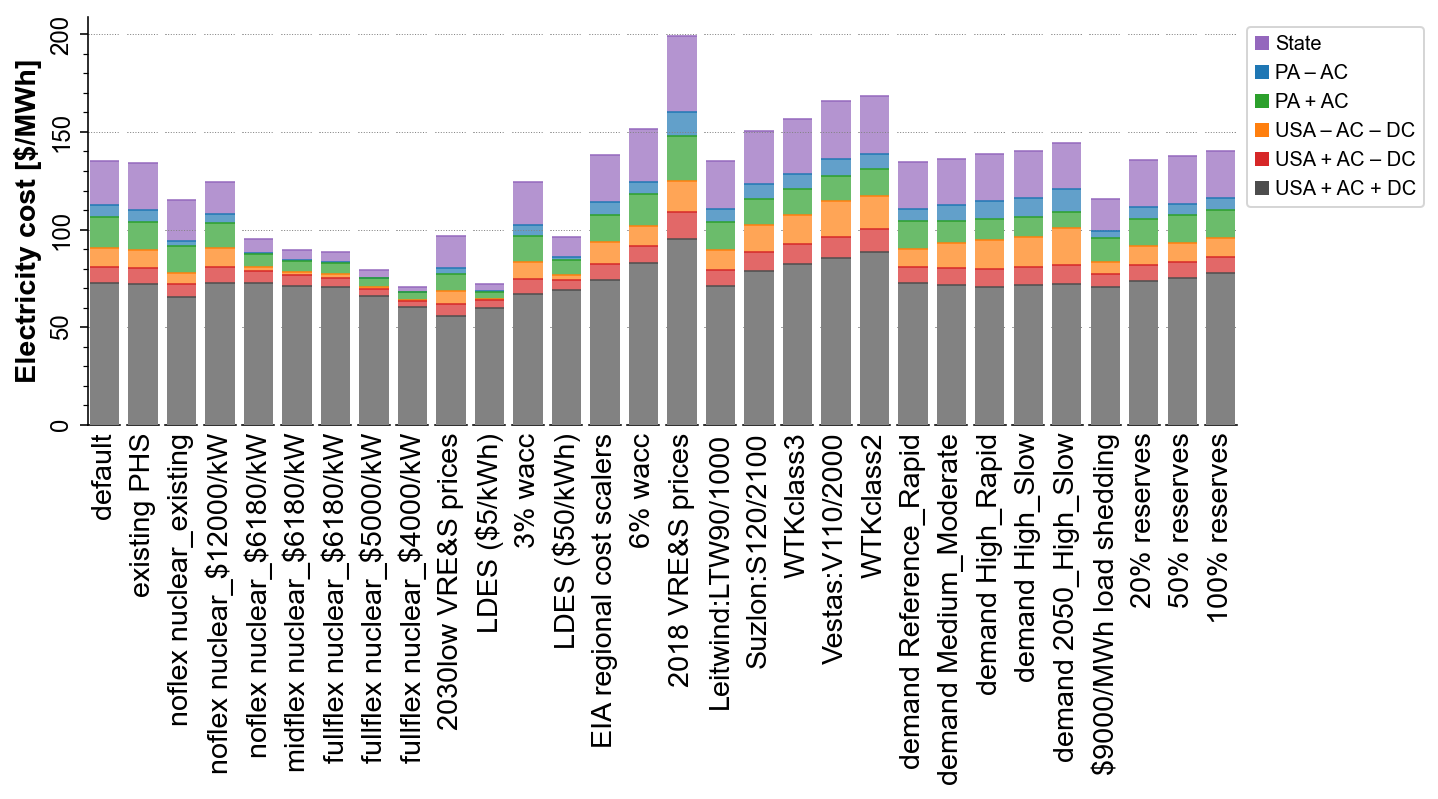

In [13]:
plt.close()
f,ax = plt.subplots(1, len(plotlabels), figsize=(figsize[0],3.75), sharex=True, sharey=True)
for col, label in enumerate(plotlabels):
    for row, scenario in enumerate(scenarios):
        val = getlcoe(label, scenario)
        ax[col].bar([2010], [val], color=colors[scenario], alpha=1, width=7, 
                    label=titles[scenario], lw=0, zorder=row)
        ### Add a marker
        ax[col].plot(
            [2006.5,2013.5], [val]*2, alpha=1, lw=0.75, label='_nolabel', zorder=100000,
            color=colors[scenario], solid_capstyle='butt', )

### Formatting
for col, label in enumerate(plotlabels):
    l = np.arange(0,501,50)
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5, zorder=20)
    ax[col].set_xlabel(label, rotation=90, weight='normal')
    ax[col].set_yticks(l)
    ax[col].set_yticklabels(l, rotation=90, va='center')
    ax[col].yaxis.set_minor_locator(AutoMinorLocator(5))
    ### Wash everything out
    ax[col].bar([2010], [210], width=7, color='w', alpha=0.3, label='_nolabel', zorder=10) ### normally alpha=0.3
        
### Formatting
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,209)
h,l = ax[-1].get_legend_handles_labels()
ax[-1].legend(h,l,loc='upper left', bbox_to_anchor=(1,1), handletextpad=0.3, handlelength=0.7,)
for row in range(len(scenarios)):
    for col in range(1, len(plotlabels)):
        zephyr.plots.despine(ax[col], left=False)
    zephyr.plots.despine(ax[0])

### Save it
if save:
    savename = 'sensitivity-USA_PA_state-SCOE'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

# Sensitivity analysis: cost scaling for individual technologies
* We only plot new transmission capacity, not existing
* We only plot inter-BA transmission capacity, not intra-BA inter-state

In [14]:
### Transmission inputs
dfdistance = pd.read_csv(
    os.path.join(projpath,'io','transmission','ba-distance-urbancentroid-km.csv'),
    index_col=0)
dfdistance_state = pd.read_csv(
    os.path.join(projpath,'io','transmission','state-distance-urbancentroid-km.csv'),
    index_col=0)

###### Transmission loss rates
loss_distance = {'ac': 0.01/1.60934/100, 'dc': 0.005/1.60934/100}

In [15]:
### Load results
dfout_costscale = pd.read_csv(
    os.path.join(projpath,'results','costscale-capacity.csv'),
    index_col=[0,1])
dictout_costscale = {int(i): dfout_costscale[i] for i in dfout_costscale.columns}

In [16]:
nogascases = {
    'PV': [3,2,1,0,4,5,6],
    'Wind': [9,8,7,0,10,11,12],
    'Stor': [15,14,13,0,16,17,18],
    'StorP': [15,14,13,0,16,17,18],
    'StorE': [15,14,13,0,16,17,18],
    'Trans': [21,20,19,0,22,23,24],
}
midgascases = {
    key: [i+25 for i in nogascases[key]]
    for key in nogascases
}
highgascases = {
    key: [i+50 for i in nogascases[key]]
    for key in nogascases
}
gascases = {'no': nogascases, 'mid': midgascases, 'high': highgascases}

In [17]:
def getpvcap(case):
    out = (
        dictout_costscale[case]['cap']
        [[c for c in dictout_costscale[case]['cap'].index if 'PV' in c]]
        .sum() / 1000
    )
    return out

def getwindcap(case):
    out = (
        dictout_costscale[case]['cap']
        [[c for c in dictout_costscale[case]['cap'].index if 'Wind' in c]]
        .sum() / 1000
    )
    return out

def getstorcapp(case):
    out = dictout_costscale[case]['cap'][
        [c for c in dictout_costscale[case]['cap'].index if (c.startswith('Stor') and c.endswith('_P'))]
    ].sum() / 1000
    return out

def getstorcape(case):
    out = dictout_costscale[case]['cap'][
        [c for c in dictout_costscale[case]['cap'].index if (c.startswith('Stor') and c.endswith('_E'))]
    ].sum() / 1000
    return out

def gettranscap(case):
    # lines = [c for c in dictout_costscale[case]['cap'].index if (('|' in c) and c.endswith('_new'))]
    lines = [c for c in dictout_costscale[case]['cap'].index if ('|' in c)]
    out = sum([
        dictout_costscale[case]['cap'][l] * dfdistance.loc[l.split('|')[0], l.split('_')[0].split('|')[1]]
        for l in lines
    ]) / 1000
    return out

In [18]:
getcap = {
    'PV': getpvcap, 'Wind': getwindcap, 'StorP': getstorcapp, 'StorE': getstorcape,
    'Trans': gettranscap,
}

In [19]:
colors = {'no': 'C0', 'mid': 'C3', 'high': 'C1'}
mults = [0.25,0.5,0.75,1.,1.25,1.5,1.75]
m = {'no':'o', 'mid':'^', 'high': 's'}
xlabels = {
    'PV': 'PV cost mult.', 'Wind': 'Wind cost mult.',
    'StorE': 'Storage cost mult.', 'StorP': 'Storage cost mult.',
    'Trans': 'Trans. cost mult.',
}
ylabels = {
    'PV': 'PV\ncapacity\n[TWac]', 
    'Wind': 'Wind\ncapacity\n[TWac]',
    'StorE': 'Storage\nenergy\n[TWh]', 
    'StorP': 'Storage\npower\n[TWac]',
    'Trans': 'Transmission\ncapacity\n[TW-km]',
}
pos = {'PV':0,'Wind':2,'Stor':1,'StorP':1,'StorE':1,'Trans':3}

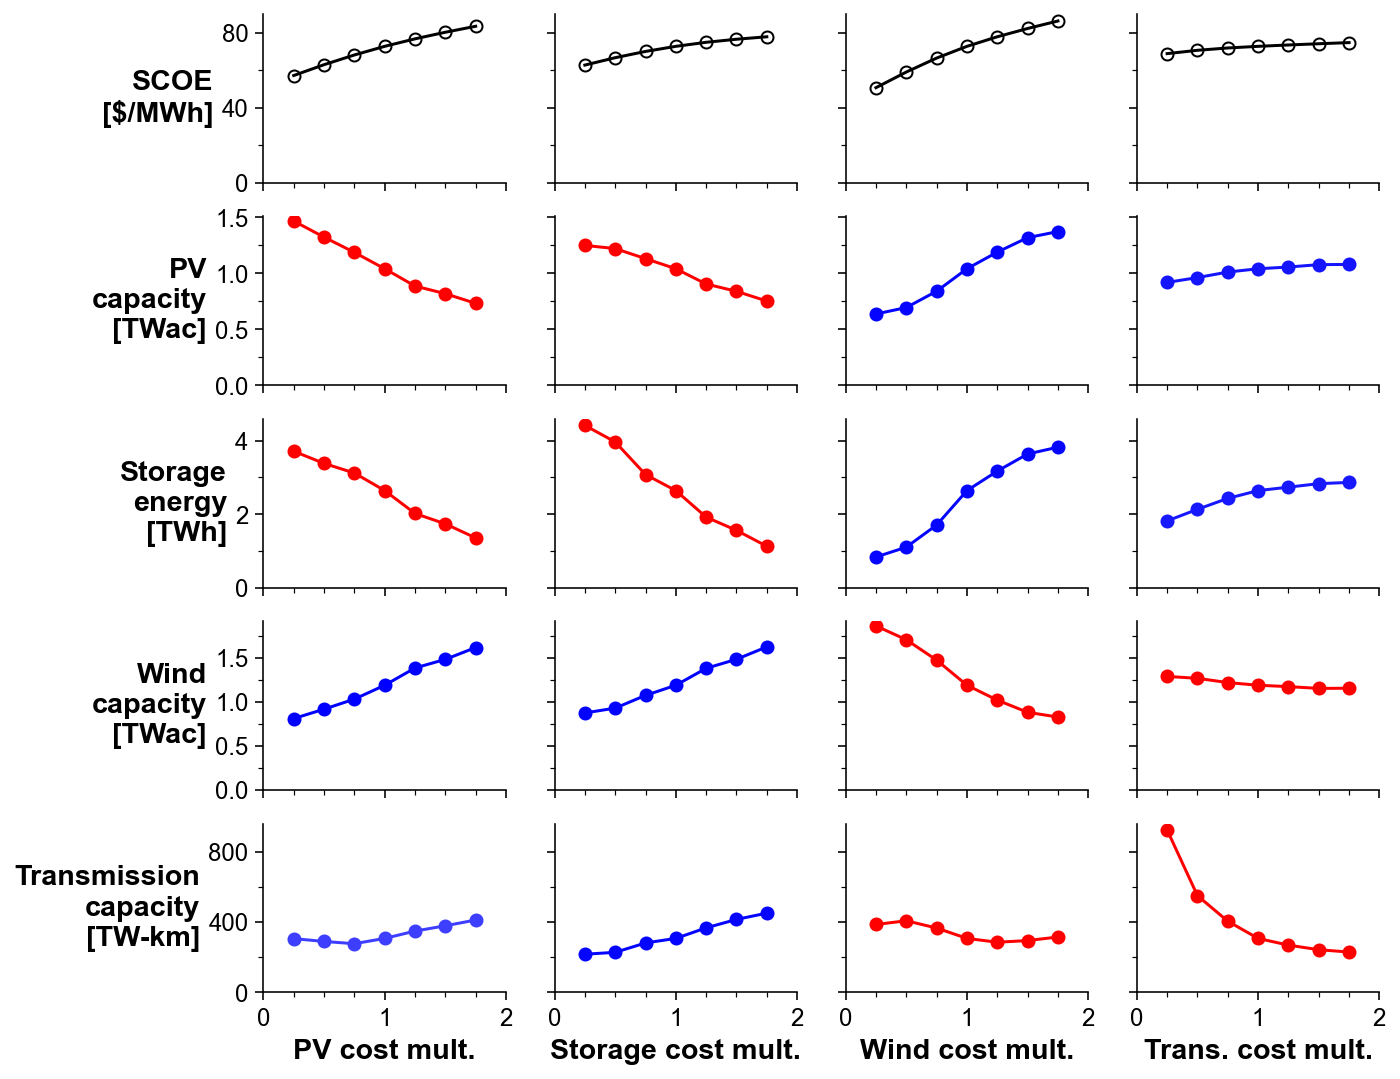

In [20]:
plt.close()
f,ax=plt.subplots(5,4,figsize=(10,9),sharex='col',sharey='row')
###### Capacities
for row in ['PV','Wind','StorE','Trans']:
    for col in ['PV','Wind','StorE','Trans']:
        for gas in ['no']:
            ax[pos[row]+1,pos[col]].plot(
                mults, 
                [getcap[row](case) for case in gascases[gas][col]],
                color=plt.cm.bwr_r(np.corrcoef(
                    mults,
                    [getcap[row](case) for case in gascases[gas][col]]
                )[1,0]), 
                marker=m[gas], label=gas,
            )
        ### Formatting
        ax[-1,pos[col]].set_xlabel(xlabels[col])
    ### Formatting
    ax[pos[row]+1,0].set_ylabel(ylabels[row], rotation=0, ha='right', va='center')
##### SCOE
for col in ['PV','Wind','StorE','Trans']:
    for gas in ['no']:
        ax[0,pos[col]].plot(
            mults,
            [dictout_costscale[case]['values','lcoe'] for case in gascases[gas][col]],
            color='k', markeredgecolor='k', markerfacecolor='none', 
            marker=m[gas], label=gas,
        )
ax[0,0].set_ylabel('SCOE\n[$/MWh]', rotation=0, ha='right', va='center')
    
###### Formatting
ax[0,0].yaxis.set_major_locator(MultipleLocator(40))
ax[1,0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[2,0].yaxis.set_major_locator(MultipleLocator(2))
ax[3,0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[4,0].yaxis.set_major_locator(MultipleLocator(400))
for row in range(5):
    ax[row,0].set_ylim(0)
    ax[row,0].yaxis.set_minor_locator(AutoMinorLocator(2))
for col in range(4):
    ax[-1,col].xaxis.set_major_locator(MultipleLocator(1))
    ax[-1,col].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[-1,col].set_xlim(0,2)
ax[0,0].set_ylim(0,90)
# plt.tight_layout()
zephyr.plots.despine(ax)
if save:
    savename = 'costscale-SCOE,PV,stor,wind,trans-colorcorr'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

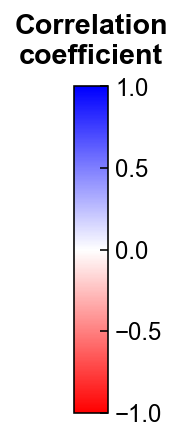

In [21]:
plt.close()
f,ax=plt.subplots(figsize=(0.3,3))
cb = mpl.colorbar.ColorbarBase(
    ax, cmap=plt.cm.bwr_r, orientation='vertical',
    norm=mpl.colors.Normalize(vmin=-1,vmax=1),
)
# cb.set_label('Correlation coefficient')
ax.annotate(
    'Correlation\ncoefficient', (0.5,1.05), xycoords='axes fraction',
    ha='center', va='bottom', weight='bold', fontsize='x-large',)
if save:
    savename = 'colorscale-vert-bwr_r'
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

# Coordination/transmission scenarios, full-US results

In [22]:
save = True
save = False

figpath = os.path.join(projpath,'results','figs','sensitivity-transmission','')
os.makedirs(figpath,exist_ok=True)

In [23]:
dictout_usa = dictout_usapacpdc.copy()
dictout_ba = dictout_bapac.copy()
xlabels = ['States','PA – AC','PA + AC',
           'USA – AC – DC', 'USA + AC – DC', 'USA + AC + DC']

## SCOE

100% reserves: 134.98 $/MWh
no new ac or dc: 112.81 $/MWh
no new dc: 106.50 $/MWh
no new ac or dc: 90.50 $/MWh
no new dc: 80.93 $/MWh
default: 72.72 $/MWh


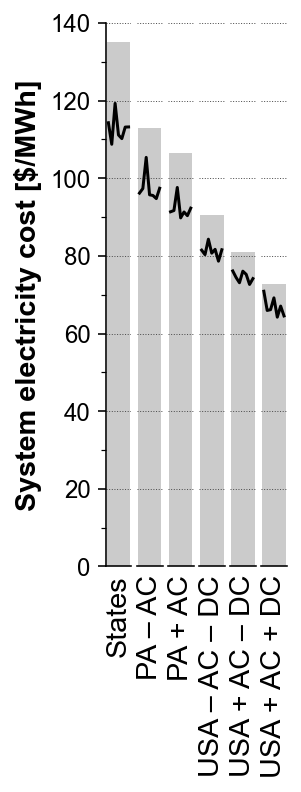

In [24]:
figsize = (13/48*6,5)
years = list(range(2007,2014))
frameon = False
color = 'C7'
alpha = 0.4
xlabels = ['States','PA – AC','PA + AC',
           'USA – AC – DC', 'USA + AC – DC', 'USA + AC + DC']

plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')
###### States
linecases = [0,1,2,3,4,5,6]
barcase = 7
### Lines
dfplot = (
    pd.concat(
        {int(caseyear[(case)]): 
         pd.Series([dictout_state[(case,state)]['values']['objective'] for state in states])
         for case in linecases
        }, 
        axis=1
    ).sum()
    / pd.concat(
        {int(caseyear[(case)]): 
         pd.Series([dictout_state[(case,state)]['values']['loadsum'] for state in states])
         for case in linecases
        }, 
        axis=1
    ).sum()
) * 1000 ### Convert to $/MWh
ax[0].plot(
    dfplot.index, dfplot.values,
    color='k', lw=1.5)
### Formatting
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[0].set_xlabel(label, rotation=90, weight='normal')
ax[0].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Bar
try:
    val = (sum([dictout_state[(barcase,state)]['values']['objective'] for state in states])
           / sum([dictout_state[(barcase,state)]['values']['loadsum'] for state in states])
          ) * 1000 ### Convert to $/MWh
except KeyError:
    pass
ax[0].bar([2010], val, color=color, alpha=alpha, width=7)
### Log
print('{}: {:.2f} $/MWh'.format(label,val))


###### PAs
for col, label in enumerate(['no new ac or dc','no new dc',]):
    ### Lines
    dfplot = (
        pd.concat(
            {int(caseyear[(case)]): 
             pd.Series([dictout_ba[(case,ba)]['values']['objective'] for ba in bas])
             for case in yearindices[label]
            }, 
            axis=1
        ).sum()
        / pd.concat(
            {int(caseyear[(case)]): 
             pd.Series([dictout_ba[(case,ba)]['values']['loadsum'] for ba in bas])
             for case in yearindices[label]
            }, 
            axis=1
        ).sum()
    ) * 1000 ### Convert to $/MWh
    ax[col+1].plot(
        dfplot.index, dfplot.values,
        color='k', lw=1.5)
    ### Formatting
    ax[col+1].set_xticks([])
    ax[col+1].set_xticklabels([])
    ax[col+1].set_xlabel(label, rotation=90, weight='normal')
    ax[col+1].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    ### Bar
    try:
        val = (sum([dictout_ba[(barindex[label],ba)]['values']['objective'] for ba in bas])
               / sum([dictout_ba[(barindex[label],ba)]['values']['loadsum'] for ba in bas])
              ) * 1000 ### Convert to $/MWh
    except KeyError:
        continue
    ax[col+1].bar([2010], val, color=color, alpha=alpha, width=7)
    ### Log
    print('{}: {:.2f} $/MWh'.format(label,val))
    
###### USA
for col, label in enumerate(['no new ac or dc','no new dc','default']):
    ### Lines
    dfplot = pd.concat(
        {int(caseyear[case]): dictout_usa[case]['values'] 
         for case in yearindices[label]
        }, 
        axis=0
    ).loc[[y for y in years],'lcoe'].reset_index(level=1,drop=True)
    ax[col+3].plot(
        dfplot.index, dfplot.values,
        color='k', lw=1.5)
    ### Formatting
    ax[col+3].set_xticks([])
    ax[col+3].set_xticklabels([])
    ax[col+3].set_xlabel(label, rotation=90, weight='normal')
    ax[col+3].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    ### Bar
    try:
        val = dictout_usa[barindex[label]]['values']['lcoe']
    except KeyError:
        continue
    ax[col+3].bar([2010], val, color=color, alpha=alpha, width=7)
    ### Log
    print('{}: {:.2f} $/MWh'.format(label,val))



### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# l = np.arange(0,201,20)
# ax[0].set_yticks(l)
# ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('System electricity cost [$/MWh]')
ax[0].set_ylim(0,140) # used to be 150
for col, xlabel in enumerate(xlabels):
    ax[col].set_xlabel(xlabel, rotation=90, weight='normal')
#     ax[col].set_xlabel(xlabel, rotation=60, 
#                        ha='right', rotation_mode='anchor', weight='normal')
for col in range(1,6):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'statebausa-SCOE-lines-bars'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Storage

default: 11.645
no new ac or dc: 8.683
no new dc: 6.672
no new ac or dc: 4.312
no new dc: 3.298
default: 2.642


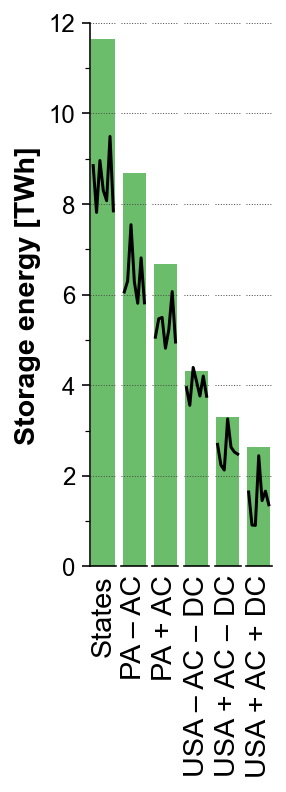

In [25]:
figsize = (13/48*6,5)
years = list(range(2007,2014))
frameon = False
color = 'C2'
alpha = 0.7
xlabels = ['States','PA – AC','PA + AC',
           'USA – AC – DC', 'USA + AC – DC', 'USA + AC + DC']

plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')
###### States
linecases = [0,1,2,3,4,5,6]
barcase = 7
### Lines
dfplot = (
    pd.Series(
        {int(caseyear[(case)]): 
             sum([dictout_state[(case,state)]['cap']['Stor_{}_E'.format(state)]
                  for state in states])
         for case in linecases}
    ) / 1000
)
ax[0].plot(
    dfplot.index, dfplot.values,
    color='k', lw=1.5)
### Formatting
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[0].set_xlabel(label, rotation=90, weight='normal')
ax[0].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Bar
val = (
    sum([dictout_state[(barcase,state)]['cap']['Stor_{}_E'.format(state)]
         for state in states])
) / 1000
ax[0].bar([2010], val, color=color, alpha=alpha, width=7)
### Log
print('{}: {:.3f}'.format(label, val))


###### PAs
for col, label in enumerate(['no new ac or dc','no new dc',]):
    ### Lines
    dfplot = (
        pd.Series(
            {int(caseyear[(case)]): 
             sum(
                 [sum(
                      [dictout_ba[(case,ba)]['cap']['Stor_{}_E'.format(state)]
                       for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values]
                  ) 
                  for ba in bas]
             )
             for case in yearindices[label]
            }
        ) / 1000
    )
    ax[col+1].plot(
        dfplot.index, dfplot.values,
        color='k', lw=1.5)
    ### Formatting
    ax[col+1].set_xticks([])
    ax[col+1].set_xticklabels([])
    ax[col+1].set_xlabel(label, rotation=90, weight='normal')
    ax[col+1].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    ### Bar
    try:
        val = (
            sum([sum(
                [dictout_ba[(barindex[label],ba)]['cap']['Stor_{}_E'.format(state)]
                 for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values]) 
            for ba in bas])
        ) / 1000
    except KeyError:
        continue
    ax[col+1].bar([2010], val, color=color, alpha=alpha, width=7)
    ### Log
    print('{}: {:.3f}'.format(label, val))
    
###### USA
for col, label in enumerate(['no new ac or dc','no new dc','default']):
    ### Lines
    dfplot = pd.Series(
        {int(caseyear[case]): 
         dictout_usa[case].loc['cap',['Stor_{}_E'.format(ba) for ba in bas]].sum() / 1000
         for case in yearindices[label]
        }
    )
    ax[col+3].plot(
        dfplot.index, dfplot.values,
        color='k', lw=1.5)
    ### Formatting
    ax[col+3].set_xticks([])
    ax[col+3].set_xticklabels([])
    ax[col+3].set_xlabel(label, rotation=90, weight='normal')
    ax[col+3].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    ### Bar
    try:
        val = dictout_usa[barindex[label]].loc['cap',['Stor_{}_E'.format(ba) for ba in bas]].sum() / 1000
    except KeyError:
        continue
    ax[col+3].bar([2010], val, color=color, alpha=alpha, width=7)
    ### Log
    print('{}: {:.3f}'.format(label, val))


### Formatting
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# l = np.arange(0,32,4)
l = np.arange(0,15,1)
# ax[0].set_yticks(l)
# ax[0].set_yticklabels(l, rotation=90, va='center')
# l = ax[0].get_yticklabels()
# ax[0].set_yticklabels(l, rotation=90)#, va='center')
ax[0].set_ylabel('Storage energy [TWh]')
# ax[0].set_ylim(0,loadmean*60/1000)
# ax[0].set_ylim(0,loadmean*16/1000)
ax[0].set_ylim(0,12)
for col, xlabel in enumerate(xlabels):
    ax[col].set_xlabel(xlabel, rotation=90, weight='normal')
#     ax[col].set_xlabel(xlabel, rotation=60, 
#                        ha='right', rotation_mode='anchor', weight='normal')
for col in range(1,6):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'statebausa-storage_twh-lines-bars'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Capacity

In [26]:
colors = {
    ('Hydro_Res',''): plt.cm.tab20(19),
    ('Hydro_ROR',''): plt.cm.tab20(9),
    ('PHS',''): plt.cm.tab20(15),
    ('Nuclear','_old'): plt.cm.tab20(13),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind',''): plt.cm.tab20(0),
    ('PV',''): plt.cm.tab20(2),
    ('Stor','_P'): plt.cm.tab20(4),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]

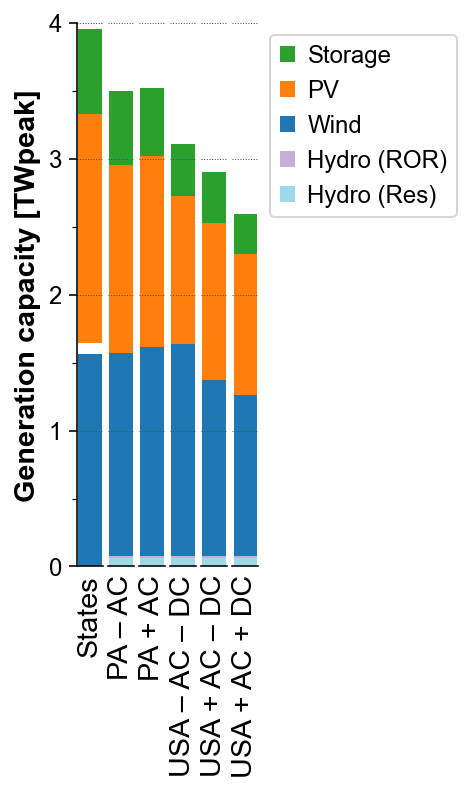

In [27]:
years = list(range(2007,2014))
frameon = False
color = 'C7'
alpha = 1

plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')
###### States
barcase = 7
dfplot = pd.Series(
    {
        'Hydro_Res': (sum([dictout_state[(barcase,state)]['cap']['Hydro_Res_{}'.format(state)]
                      if 'Hydro_Res_{}'.format(state) 
                      in dictout_state[(barcase,state)]['cap'].index
                      else 0
                      for state in states])),
        'Hydro_ROR': (sum([dictout_state[(barcase,state)]['cap']['Hydro_ROR_{}'.format(state)]
                      if 'Hydro_ROR_{}'.format(state) 
                      in dictout_state[(barcase,state)]['cap'].index
                      else 0
                      for state in states])),
        'PHS': (sum([dictout_state[(barcase,state)]['cap']['PHS_{}_P'.format(state)]
                      if 'PHS_{}_P'.format(state) 
                      in dictout_state[(barcase,state)]['cap'].index
                      else 0
                      for state in states])),
        'Nuclear_old': (sum([dictout_state[(barcase,state)]['cap']['Nuclear_{}_old'.format(state)]
                      if 'Nuclear_{}_old'.format(state) 
                      in dictout_state[(barcase,state)]['cap'].index
                      else 0
                      for state in states])),
        'Nuclear_new': (sum([dictout_state[(barcase,state)]['cap']['Nuclear_{}_new'.format(state)]
                      if 'Nuclear_{}_new'.format(state) 
                      in dictout_state[(barcase,state)]['cap'].index
                      else 0
                      for state in states])),
        'Wind': sum([
            dictout_state[(barcase,state)]['cap'][
                [c for c in dictout_state[(barcase,state)]['cap'].index if c.startswith('Wind')]
            ].sum()
            for state in states
        ]),
        'PV': sum([
            dictout_state[(barcase,state)]['cap'][
                [c for c in dictout_state[(barcase,state)]['cap'].index if c.startswith('PV')]
            ].sum()
            for state in states
        ]),
        'Stor': (sum([dictout_state[(barcase,state)]['cap']['Stor_{}_P'.format(state)]
                    for state in states])),
        'OCGT': (sum([dictout_state[(barcase,state)]['cap']['OCGT_{}'.format(state)]
                      if 'OCGT_{}'.format(state) 
                      in dictout_state[(barcase,state)]['cap'].index
                      else 0
                      for state in states])),
        'CCGT': (sum([dictout_state[(barcase,state)]['cap']['CCGT_{}'.format(state)]
                      if 'CCGT_{}'.format(state) 
                      in dictout_state[(barcase,state)]['cap'].index
                      else 0
                      for state in states])),
    }
) / 1000
ax[0].bar(
    x=[2010], 
    height=dfplot.values, 
    bottom=dfplot.cumsum().shift(1).fillna(0),
    width=7, color=colorlist,
)
### Formatting
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('default' if label == 'no new dc' else label, 
                   rotation=90, weight='normal')
ax[0].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)


###### PA
for col, label in enumerate(['no new ac or dc','no new dc']):
    ### Individual years
    dfplot = pd.concat(
        [
            pd.DataFrame(
                {
                    'Hydro_Res': (sum([dictout_ba[(barindex[label],ba)]['cap']['Hydro_Res_{}'.format(state)]
                                  if 'Hydro_Res_{}'.format(state) 
                                  in dictout_ba[(barindex[label],ba)]['cap'].index
                                  else 0
                                  for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                    'Hydro_ROR': (sum([dictout_ba[(barindex[label],ba)]['cap']['Hydro_ROR_{}'.format(state)]
                                  if 'Hydro_ROR_{}'.format(state) 
                                  in dictout_ba[(barindex[label],ba)]['cap'].index
                                  else 0
                                  for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                    'PHS': (sum([dictout_ba[(barindex[label],ba)]['cap']['PHS_{}_P'.format(state)]
                                  if 'PHS_{}_P'.format(state) 
                                  in dictout_ba[(barindex[label],ba)]['cap'].index
                                  else 0
                                  for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                    'Nuclear_old': (sum([dictout_ba[(barindex[label],ba)]['cap']['Nuclear_{}_old'.format(state)]
                                  if 'Nuclear_{}_old'.format(state) 
                                  in dictout_ba[(barindex[label],ba)]['cap'].index
                                  else 0
                                  for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                    'Nuclear_new': (sum([dictout_ba[(barindex[label],ba)]['cap']['Nuclear_{}_new'.format(state)]
                                  if 'Nuclear_{}_new'.format(state) 
                                  in dictout_ba[(barindex[label],ba)]['cap'].index
                                  else 0
                                  for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                    'Wind': dictout_ba[(barindex[label],ba)]['cap'][
                        [c for c in dictout_ba[(barindex[label],ba)]['cap'].index if c.startswith('Wind')]
                    ].sum(),
                    'PV': dictout_ba[(barindex[label],ba)]['cap'][
                        [c for c in dictout_ba[(barindex[label],ba)]['cap'].index if c.startswith('PV')]
                    ].sum(),
                    'Stor': (sum([dictout_ba[(barindex[label],ba)]['cap']['Stor_{}_P'.format(state)]
                                for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                    'OCGT': (sum([dictout_ba[(barindex[label],ba)]['cap']['OCGT_{}'.format(state)]
                                  if 'OCGT_{}'.format(state) 
                                  in dictout_ba[(barindex[label],ba)]['cap'].index
                                  else 0
                                  for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                    'CCGT': (sum([dictout_ba[(barindex[label],ba)]['cap']['CCGT_{}'.format(state)]
                                  if 'CCGT_{}'.format(state) 
                                  in dictout_ba[(barindex[label],ba)]['cap'].index
                                  else 0
                                  for state in dfstate.loc[dfstate[('area','ba')]==ba].index.values])),
                }, index=[ba]
            ).T
            for ba in bas
        ], axis=1
    ).sum(axis=1) / 1000
    ax[col+1].bar(
        x=[2010], 
        height=dfplot.values, 
        bottom=dfplot.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    ### Formatting
    ax[col+1].set_xticks([])
    ax[col+1].set_xticklabels([])
    ax[col+1].set_xlabel('default' if label == 'no new dc' else label, 
                       rotation=90, weight='normal')
    ax[col+1].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)

###### USA
for col, label in enumerate(['no new ac or dc','no new dc','default']):
    ### Individual years
    gens = dictout_usa[barindex[label]]['cap'].index.values
    dfplot = pd.Series({
                '{}{}'.format(*gen): 
                dictout_usa[barindex[label]]['cap'][
                    [c for c in gens if c.startswith(gen[0]) and c.endswith(gen[1])]
                ].sum()
                for gen in colors
            }) / 1000
    ax[col+3].bar(
        x=[2010], 
        height=dfplot.values, 
        bottom=dfplot.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    ### Formatting
    ax[col+3].set_xticks([])
    ax[col+3].set_xticklabels([])
    ax[col+3].set_xlabel(label, rotation=90, weight='normal')
    ax[col+3].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    
### Legend (by hand)
legendcolors = {
    'Hydro (Res)': plt.cm.tab20(19),
    'Hydro (ROR)': plt.cm.tab20(9),
    # 'PHS': plt.cm.tab20(15),
    # 'Nuclear': plt.cm.tab20(13),
    'Wind': plt.cm.tab20(0),
    'PV': plt.cm.tab20(2),
    'Storage': plt.cm.tab20(4),
    # 'CCGT': plt.cm.tab20(10),
}
handles = [
    mpl.patches.Patch(facecolor=legendcolors[i], edgecolor='none', label=i)
    for i in legendcolors
]
leg = ax[-1].legend(
    handles=handles[::-1],loc='upper left',bbox_to_anchor=(1,1),fontsize='large',
    frameon=True, handletextpad=0.5, handlelength=0.65,
)
### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(1))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# l = np.arange(0,6,1) ### or 0.5
# ax[0].set_yticks(l)
# ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Generation capacity [TWpeak]')
ax[0].set_ylim(0,4.)
for col, xlabel in enumerate(xlabels):
    ax[col].set_xlabel(xlabel, rotation=90, weight='normal')
for col in range(1,6):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'statebausa-capacity-7yearbar'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## SCOE components

In [28]:
colors = {
    ('Hydro_Res','',''): plt.cm.tab20(19),
    ('Hydro_ROR','',''): plt.cm.tab20(9),
    ('PHS','',''): plt.cm.tab20(15),
    ('Nuclear','','_old'): plt.cm.tab20(13),
    ('Nuclear','','_new'): plt.cm.tab20(13),
    ('Wind','',''): plt.cm.tab20(0),
    ('PV','',''): plt.cm.tab20(2),
    ('Stor','',''): plt.cm.tab20(4),
    ('CCGT','',''): plt.cm.tab20(10),
    ('OCGT','',''): plt.cm.tab20(16),
    ('','|',''): plt.cm.binary(1000),
}
colorlist = [colors[c] for c in colors]

0.00 $/MWh transmission, 90.50 $/MWh total
1.15 $/MWh transmission, 80.93 $/MWh total
2.30 $/MWh transmission, 72.72 $/MWh total


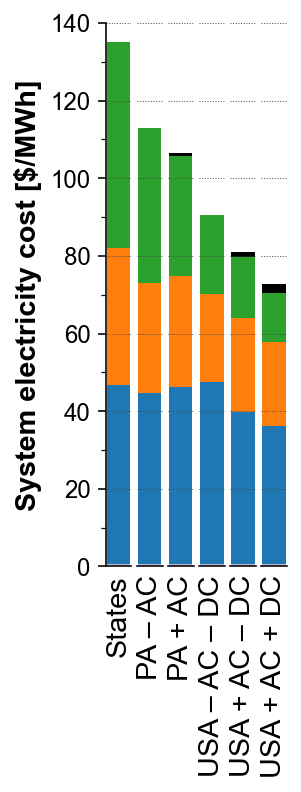

In [29]:
figsize = (13/48*6,5)
years = list(range(2007,2014))
frameon = False
xlabels = ['States','PA – AC','PA + AC',
           'USA – AC – DC', 'USA + AC – DC', 'USA + AC + DC']

plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')
###### States
case = 7
dictplot = {}
for state in states:
    gens = dictout_state[(case,state)]['cost'].index.values
    dictplot[state] = pd.Series({
        '{}{}{}'.format(*gen): 
        dictout_state[(case,state)]['cost'][
            [c for c in gens if (
                c.startswith(gen[0]) and (gen[1] in c) and c.endswith(gen[2]))]
        ].sum()
        for gen in colors
    })
dfplot = pd.concat(dictplot, axis=1).sum(axis=1) / (
     pd.Series([dictout_state[(case,state)]['values']['loadsum'] for state in states]).sum()
) * 1000
ax[0].bar(
    x=[2010]*len(dfplot), 
    height=dfplot.values, 
    bottom=dfplot.cumsum().shift(1).fillna(0),
    width=7, color=colorlist,
)

###### PAs
for col, label in enumerate(['no new ac or dc','no new dc',]):
    case = barindex[label]
    dictplot = {}
    for ba in bas:
        gens = dictout_ba[(case,ba)]['cost'].index.values
        dictplot[ba] = pd.Series({
            '{}{}{}'.format(*gen): 
            dictout_ba[(case,ba)]['cost'][
                [c for c in gens if (
                    c.startswith(gen[0]) and (gen[1] in c) and c.endswith(gen[2]))]
            ].sum()
            for gen in colors
        })
    dfplot = pd.concat(dictplot, axis=1).sum(axis=1) / (
         pd.Series([dictout_ba[(case,ba)]['values']['loadsum'] for ba in bas]).sum()
    ) * 1000
    ax[col+1].bar(
        x=[2010]*len(dfplot), 
        height=dfplot.values, 
        bottom=dfplot.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    
###### USA
for col, label in enumerate(['no new ac or dc','no new dc','default']):
    case = barindex[label]
    gens = dictout_usa[case]['cost'].index.values
    dfplot = pd.Series({
        '{}{}{}'.format(*gen): 
        dictout_usa[case]['cost'][
            [c for c in gens if (
                c.startswith(gen[0]) and (gen[1] in c) and c.endswith(gen[2]))]
        ].sum() / dictout_usa[case]['values']['loadsum'] * 1000
        for gen in colors
    })
    ax[col+3].bar(
        x=[2010]*len(dfplot), 
        height=dfplot.values, 
        bottom=dfplot.cumsum().shift(1).fillna(0),
        width=7, color=colorlist,
    )
    ### Log
    print('{:.2f} $/MWh transmission, {:.2f} $/MWh total'.format(dfplot['|'],dfplot.sum()))

### Formatting
for col in range(6):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(xlabels[col], rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)    

### Formatting
ax[0].yaxis.set_major_locator(MultipleLocator(20))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# l = np.arange(0,201,20)
# ax[0].set_yticks(l)
# ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('System electricity cost [$/MWh]')
ax[0].set_ylim(0,140) # used to be 150
for col, xlabel in enumerate(xlabels):
    ax[col].set_xlabel(xlabel, rotation=90, weight='normal')
#     ax[col].set_xlabel(xlabel, rotation=60, 
#                        ha='right', rotation_mode='anchor', weight='normal')
for col in range(1,6):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'statebausa-SCOEbreakdown-7yearbar'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Dispatched energy

In [30]:
colors = {
    ('Stor','_P'): plt.cm.tab20(4),
    ('PHS',''): plt.cm.tab20(15),
    # ('PHS',''): plt.cm.binary(1000),
    ('HydroROR',''): plt.cm.tab20(9),
    ('HydroRes',''): plt.cm.tab20(19),
    ('Nuclear','_old'): plt.cm.tab20(13),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind',''): plt.cm.tab20(0),
    ('PV',''): plt.cm.tab20(2),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]

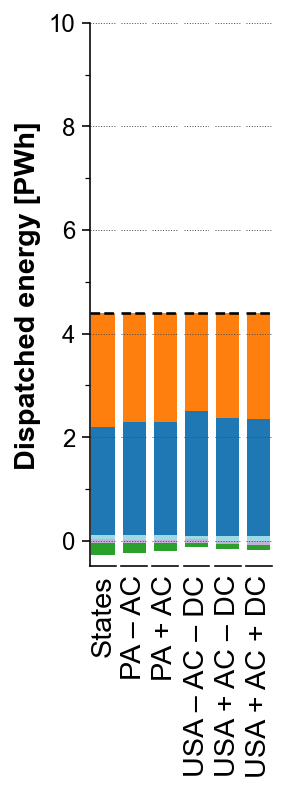

In [31]:
labels = ['States','PA – AC','PA + AC',
          'USA – AC – DC', 'USA + AC – DC', 'USA + AC + DC']

plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')

###### States
linecases = [0,1,2,3,4,5,6]
barcase = 7
### Load line
loadsum = sum(
    [dictout_state[(linecases[0],state)]['values']['loadsum'] for state in states]
) / 1E6
ax[0].axhline(loadsum, c='k', lw=1.3, ls='--')
### Full 7 years
case = barcase
dictplot = {}
for state in states:
    ### Aggregate the generation
    df = dictout_state[(case,state)]['energy']
    gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
    ### Make generator-specific cols (gross)
    plotcols = {
        'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
        'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
        'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
        'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
        'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
        # 'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
        'HydroRes': [c for c in gencols if c.startswith('Hydro_Res') and c.endswith('_power')],
        'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
        'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
        'Wind': ['Wind_all'],
        'PV': ['PV_all'],
        'CCGT': [c for c in gencols if c.startswith('CCGT')],
        'OCGT': [c for c in gencols if c.startswith('OCGT')],
    }
    dictplot[state] = pd.Series(
        {c: df[plotcols[c]].sum() for c in plotcols}
    ) / 1E6 / len(years) ### convert to PWh, correct for number of years
    dfplot = pd.concat(dictplot,axis=1).sum(axis=1)

    ### No transmission losses
    start = dfplot[['Stor_charge','PHS_charge']].sum()
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[0].bar(
        x=[2010]*len(bottom), bottom=bottom.values, height=-height.values,
        width=7, color=colorlist,
    )

###### PA
for col, label in enumerate(['no new ac or dc','no new dc']):
    ### Load line
    loadsum = sum(
        [dictout_ba[(yearindices[label][0],ba)]['values']['loadsum'] for ba in bas]
    ) / 1E6
    ax[col+1].axhline(loadsum, c='k', lw=1.3, ls='--')
    ### Full 7 years
    case = barindex[label]
    dictplot = {}
    balosses = []
    for ba in bas:
        ### Aggregate the generation
        df = dictout_ba[(case,ba)]['energy']
        gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
        ### Make generator-specific cols (gross)
        plotcols = {
            'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
            'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
            'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
            'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
            'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
            # 'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
            'HydroRes': [c for c in gencols if c.startswith('Hydro_Res') and c.endswith('_power')],
            'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
            'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
            'Wind': ['Wind_all'],
            'PV': ['PV_all'],
            'CCGT': [c for c in gencols if c.startswith('CCGT')],
            'OCGT': [c for c in gencols if c.startswith('OCGT')],
        }
        dictplot[ba] = pd.Series(
            {c: df[plotcols[c]].sum() for c in plotcols}
        ) / 1E6 / len(years) ### convert to PWh, correct for number of years

        ### Calculate transmission losses
        tcols = [c for c in dictout_ba[(case,ba)]['energy'].index if '|' in c]
        translosses = []
        for c in tcols:
            node1 = c.split('|')[0]
            node2 = c.split('|')[1].split('_')[0]
            linetype = c.split('_')[1]
            translosses.append(
            abs(dictout_ba[(case,ba)]['energy'].fillna(0)[c]) 
            * dfdistance_state.loc[node1,node2] * loss_distance[linetype]
        )
        balosses.append(sum(translosses) / 1E6 / len(years))

    dfplot = pd.concat(dictplot,axis=1).sum(axis=1)
    translosses = sum(balosses)
    ### Continue
    start = dfplot[['Stor_charge','PHS_charge']].sum() - translosses
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[col+1].bar(
        x=[2010]*len(bottom), bottom=bottom.values, height=-height.values, 
        width=7, color=colorlist,
    )

###### USA
for col, label in enumerate(['no new ac or dc','no new dc','default']):
    ### Load line
    ### Use this version while some are not yet done
    case = barindex[label]
    gens = dictout_usa[case]['cap'].index.values
    loadsum = dictout_usa[case]['values']['loadsum'] / 7E6
    ### Plot the total load
    ax[col+3].axhline(loadsum, c='k', lw=1.3, ls='--')
    ### Aggregate the generation
    df = dictout_usa[case]['energy']
    gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
    ### Make generator-specific cols (gross)
    plotcols = {
        'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
        'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
        'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
        'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
        'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
        # 'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
        'HydroRes': [c for c in gencols if c.startswith('Hydro_Res') and c.endswith('_power')],
        'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
        'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
        # 'Wind': ['Wind_all'],
        'Wind': [c for c in gencols if c.startswith('Wind') and ('_all' not in c)],
        'PV': ['PV_all'],
        'CCGT': [c for c in gencols if c.startswith('CCGT')],
        'OCGT': [c for c in gencols if c.startswith('OCGT')],
    }
    dfplot = pd.Series(
        {c: df[plotcols[c]].sum() for c in plotcols}
    ) / 1E6 / len(years) ### convert to PWh, correct for number of years

    ### Calculate transmission losses
    tcols = [c for c in dictout_usa[case]['energy'].index if '|' in c]
    translosses = []
    for c in tcols:
        node1 = c.split('|')[0]
        node2 = c.split('|')[1].split('_')[0]
        linetype = c.split('_')[1]
        translosses.append(
            abs(dictout_usa[case]['energy'].fillna(0)[c]) 
            * dfdistance.loc[node1,node2] * loss_distance[linetype]
        )
    translosses = sum(translosses) / 7E6
    ### Continue
    start = dfplot[['Stor_charge','PHS_charge']].sum() - translosses
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[col+3].bar(
        x=[2010]*len(bottom), 
        bottom=bottom.values, 
        height=-height.values,
        width=7, color=colorlist,
    )

### Formatting
for col in range(6):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(labels[col], rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)    
ax[0].yaxis.set_major_locator(MultipleLocator(2))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# l = np.arange(-2,13,2)
# ax[0].set_yticks(l)
# ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Dispatched energy [PWh]')
ax[0].set_ylim(-0.5,10)
ax[0].set_xlim(2006.15, 2013.85)
for col in range(1,6):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'statebausa-energy_dispatched-7yearbar'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Available energy

In [32]:
###############################
### PV yearly availability, PAs
def pvfile(zone,bins): 
    pvpath = os.path.join(projpath,'io','cf-2007_2013','1x','ba','pv','track-0t-180az','binned','')
    return '{}cf-nsrdb,icomesh9-track-0t-180az-1.30dcac-86USDperkWacyr-ba_{}-{}lcoebins.csv'.format(
        pvpath, zone, bins)

cfpv_ba = {}
cfpv_ba_hourly = {}
for ba in tqdm(bas):
    numbins_pv = dfregion.loc[ba,'numbins_pv']
    bins_pv = dfregion.loc[ba,'bins_pv'].split(',')
    dfpv = pd.read_csv(
        pvfile(ba,numbins_pv), index_col=0, parse_dates=True
    )[bins_pv].tz_convert(tz)
    dfpv = (
        dfpv.drop(dfpv.loc['2008-02-29'].index)
        .drop(dfpv.loc['2012-02-29'].index)
        .drop(dfpv.loc['2013-12-31'].index)
    )
    cfpv_ba_hourly[ba] = dfpv.copy()
    for year in years:
        cfpv_ba[ba,str(year)] = float(dfpv.loc[str(year)].mean())

In [33]:
#################################
### Wind yearly availability, PAs
def windfile(zone,bins,model='Gamesa:G126/2500_low'): 
    modelsave = model.replace(':','|').replace('/','_').replace(' ','')
    windpath = os.path.join(projpath,'io','cf-2007_2013','1x','ba','wind','{}','binned','').format(
        modelsave)
    return ('{}cf-wtkhsds,every2,offset0,onshore-{}-100m-'
            '19pctloss-121USDperkWacyr-ba_{}-{}lcoebins.csv').format(
        windpath, modelsave, zone, bins)

cfwind_ba = {}
cfwind_ba_hourly = {}
models = ['Gamesa:G126/2500_low',
          #'WTKclass3','Leitwind:LTW90/1000','Suzlon:S120/2100','Vestas:V110/2000','WTKclass2',
         ]
for ba in tqdm(bas):
    for model in models:
        numbins_wind = dfregion.loc[ba,'numbins_wind']
        bins_wind = dfregion.loc[ba,'bins_wind'].split(',')
        dfwind = pd.read_csv(
            windfile(ba,numbins_wind,model), index_col=0, parse_dates=True
        )[bins_wind].tz_convert(tz)
        dfwind = (
            dfwind.drop(dfwind.loc['2008-02-29'].index)
            .drop(dfwind.loc['2012-02-29'].index)
            .drop(dfwind.loc['2013-12-31'].index)
        )
        cfwind_ba_hourly[ba,model] = dfwind.copy()
        for year in years:
            cfwind_ba[ba,model,str(year)] = dfwind.loc[str(year)].mean()

In [34]:
##################################
### PV yearly availability, states
def pvfile(zone,bins): 
    pvpath = os.path.join(projpath,'io','cf-2007_2013','1x','state','pv','track-0t-180az','binned','')
    return '{}cf-nsrdb,icomesh9-track-0t-180az-1.30dcac-86USDperkWacyr-state_{}-{}lcoebins.csv'.format(
        pvpath, zone, bins)

cfpv_state = {}
cfpv_state_hourly = {}
for state in tqdm(states):
    numbins_pv = dfstate.loc[state,('numbins_pv','state')]
    bins_pv = dfstate.loc[state,('bins_pv','state')].split(',')
    dfpv = pd.read_csv(
        pvfile(state,numbins_pv), index_col=0, parse_dates=True
    )[bins_pv].tz_convert(tz)
    dfpv = (
        dfpv.drop(dfpv.loc['2008-02-29'].index)
        .drop(dfpv.loc['2012-02-29'].index)
        .drop(dfpv.loc['2013-12-31'].index)
    )
    cfpv_state_hourly[state] = dfpv.copy()
    for year in years:
        cfpv_state[state,str(year)] = dfpv.loc[str(year)].mean()

In [35]:
####################################
### Wind yearly availability, states
def windfile(zone,bins,model='Gamesa:G126/2500_low'): 
    modelsave = model.replace(':','|').replace('/','_').replace(' ','')
    windpath = os.path.join(projpath,'io','cf-2007_2013','1x','state','wind','{}','binned','').format(
        modelsave)
    return ('{}cf-wtkhsds,every2,offset0,onshore-{}-100m-'
            '19pctloss-121USDperkWacyr-state_{}-{}lcoebins.csv').format(
        windpath, modelsave, zone, bins)

cfwind_state = {}
cfwind_state_hourly = {}
models = ['Gamesa:G126/2500_low',
          #'WTKclass3','Leitwind:LTW90/1000','Suzlon:S120/2100','Vestas:V110/2000','WTKclass2',
         ]
for state in tqdm(states):
    for model in models:
        numbins_wind = dfstate.loc[state,('numbins_wind','state')]
        bins_wind = dfstate.loc[state,('bins_wind','state')].split(',')
        dfwind = pd.read_csv(
            windfile(state,numbins_wind,model), index_col=0, parse_dates=True
        )[bins_wind].tz_convert(tz)
        dfwind = (
            dfwind.drop(dfwind.loc['2008-02-29'].index)
            .drop(dfwind.loc['2012-02-29'].index)
            .drop(dfwind.loc['2013-12-31'].index)
        )
        cfwind_state_hourly[state,model] = dfwind.copy()
        for year in years:
            cfwind_state[state,model,str(year)] = dfwind.loc[str(year)].mean()

In [36]:
colors = {
    ('Stor','_P'): plt.cm.tab20(4),
    ('PHS',''): plt.cm.tab20(15),
    # ('PHS',''): plt.cm.binary(1000),
    ('HydroROR',''): plt.cm.tab20(9),
    ('HydroRes',''): plt.cm.tab20(19),
    ('Nuclear','_old'): plt.cm.tab20(13),
    ('Nuclear','_new'): plt.cm.tab20(13),
    ('Wind',''): plt.cm.tab20(0),
    ('PV',''): plt.cm.tab20(2),
    ('CCGT',''): plt.cm.tab20(10),
    ('OCGT',''): plt.cm.tab20(16),
}
colorlist = [colors[c] for c in colors]

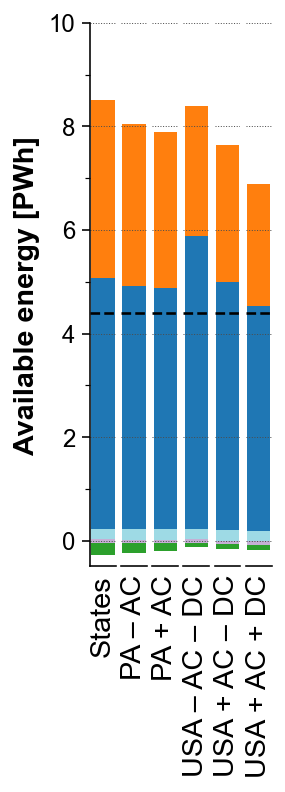

In [37]:
labels = ['States','PA – AC','PA + AC',
          'USA – AC – DC', 'USA + AC – DC', 'USA + AC + DC']
plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')

###### States
linecases = [0,1,2,3,4,5,6]
barcase = 7
pvbins = [0,1,2,3,4]
windbins = [0,1,2,3,4]
### Load line
loadsum = sum(
    [dictout_state[(linecases[0],state)]['values']['loadsum'] for state in states]
) / 1E6
ax[0].axhline(loadsum, c='k', lw=1.3, ls='--')
### Full 7 years
case = barcase
dictplot = {}
for state in states:
    ### Aggregate the generation
    df= dictout_state[barcase,state]['energy']
    gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
    ### Make generator-specific cols (gross)
    plotcols = {
        'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
        'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
        'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
        'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
        'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
        'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
        'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
        'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
        'Wind': ['Wind_all'],
        'PV': ['PV_all'],
        'CCGT': [c for c in gencols if c.startswith('CCGT')],
        'OCGT': [c for c in gencols if c.startswith('OCGT')],
    }
    dictplot[state] = pd.Series(
        {c: df[plotcols[c]].sum() for c in plotcols}
    ) / len(years)
dfplot = pd.concat(dictplot,axis=1).sum(axis=1)

### Replace dispatchable columns with capacity * CF
dfplot['PV'] = sum(
    [
        (dictout_state[(case,state)]['cap']['PV_{}_{}'.format(state,pvbin)] * casehours[case]
         * cfpv_state[state,caseyear[case]][pvbin]
        )
        for state in states for pvbin in pvbins for case in linecases
    ]
) / len(years)
dfplot['Wind'] = sum(
    [
        (dictout_state[(case,state)]['cap']['Wind_{}_{}'.format(state,windbin)] * casehours[case]
         * cfwind_state[state,cases.loc[case,'wind_model'],caseyear[case]][windbin]
        )
        for state in states for windbin in windbins for case in linecases
    ]
) / len(years)
if dfplot['NuclearOld'] > 0:
    dfplot['NuclearOld'] = sum([
        dictout_state[(case,state)]['cap']['Nuclear_{}_old'.format(state)] * casehours[case] * 1
        for state in states for case in linecases
    ]) / len(years)
if dfplot['NuclearNew'] > 0:
    dfplot['NuclearNew'] = sum([
        dictout_state[(case,state)]['cap']['Nuclear_{}_new'.format(state)] * casehours[case] * 1
        for state in states for case in linecases
    ]) / len(years)
for g in ['CCGT','OCGT']:
    if dfplot[g] > 0:
        dfplot[g] = sum([
            dictout_state[(case,state)]['cap'].loc['{}_{}'.format(g,state)] * casehours[case] * 1
            for state in states for case in linecases
        ]) / len(years)

### Convert to PWh
dfplot = dfplot / 1E6
### Continue
start = dfplot[['Stor_charge','PHS_charge']].sum()
height = dfplot.loc['Stor_discharge':]
bottom = height.cumsum() + start
### Plot it
ax[0].bar(
    x=[2010]*len(bottom), bottom=bottom.values, height=-height.values,
    width=7, color=colorlist,
)

###### PA
pvbins = [0]
windbins = [0,1,2,3,4]
for col, label in enumerate(['no new ac or dc','no new dc']):
    ### Load line
    loadsum = sum(
        [dictout_ba[(yearindices[label][0],ba)]['values']['loadsum'] for ba in bas]
    ) / 1E6
    ax[col+1].axhline(loadsum, c='k', lw=1.3, ls='--')
    ### Full 7 years
    barcase = barindex[label]
    dictplot = {}
    balosses = []
    for ba in bas:
        ### Aggregate the generation
        df = dictout_ba[(barcase,ba)]['energy']
        gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
        ### Make generator-specific cols (gross)
        plotcols = {
            'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
            'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
            'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
            'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
            'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
            'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
            'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
            'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
            'Wind': ['Wind_all'],
            'PV': ['PV_all'],
            'CCGT': [c for c in gencols if c.startswith('CCGT')],
            'OCGT': [c for c in gencols if c.startswith('OCGT')],
        }
        dictplot[ba] = pd.Series(
            {c: df[plotcols[c]].sum() for c in plotcols}
        ) / len(years)
        ### Calculate transmission losses
        tcols = [c for c in dictout_ba[(barcase,ba)]['energy'].index if '|' in c]
        translosses = []
        for c in tcols:
            node1 = c.split('|')[0]
            node2 = c.split('|')[1].split('_')[0]
            linetype = c.split('_')[1]
            translosses.append(
                abs(dictout_ba[(barcase,ba)]['energy'].fillna(0)[c]) 
                * dfdistance_state.loc[node1,node2] * loss_distance[linetype]
            )
        balosses.append(sum(translosses) / 1E6 / len(years))

    dfplot = pd.concat(dictplot,axis=1).sum(axis=1)
    translosses = sum(balosses)
    ### Replace dispatchable columns with capacity * CF
    dfplot['PV'] = sum(
        [
            (dictout_ba[(case,ba)]['cap']['PV_{}_{}'.format(state,pvbin)] * casehours[case]
             * cfpv_state[state,caseyear[case]][pvbin]
            )
            for ba in bas
            for state in dfstate.loc[dfstate.area.ba==ba].index.values
            for pvbin in pvbins
            for case in yearindices[label]
        ]
    ) / len(years)
    dfplot['Wind'] = sum(
        [
            (dictout_ba[(case,ba)]['cap']['Wind_{}_{}'.format(state,windbin)] * casehours[case]
             * cfwind_state[state,cases.loc[case,'wind_model'],caseyear[case]][windbin]
            )
            for ba in bas
            for state in dfstate.loc[dfstate.area.ba==ba].index.values
            for windbin in windbins
            for case in yearindices[label]
        ]
    ) / len(years)
    if dfplot['NuclearOld'] > 0:
        dfplot['NuclearOld'] = sum([
            dictout_ba[(barcase,ba)]['cap']['Nuclear_{}_old'.format(state)] * casehours[case] * 1
            for ba in bas
            for state in dfstate.loc[dfstate.area.ba==ba].index.values
            for case in yearindices[label]
        ]) / len(years)
    if dfplot['NuclearNew'] > 0:
        dfplot['NuclearNew'] = sum([
            dictout_ba[(barcase,ba)]['cap']['Nuclear_{}_new'.format(state)] * casehours[case] * 1
            for ba in bas
            for state in dfstate.loc[dfstate.area.ba==ba].index.values
            for case in yearindices[label]
        ]) / len(years)
    for g in ['CCGT','OCGT']:
        if dfplot[g] > 0:
            dfplot[g] = sum([
                dictout_ba[(barcase,ba)]['cap'].loc['{}_{}'.format(g,state)] * casehours[case] * 1
                for ba in bas
                for state in dfstate.loc[dfstate.area.ba==ba].index.values
                for case in yearindices[label]
            ]) / len(years)

    ### Convert to PWh
    dfplot = dfplot / 1E6
    ### Continue
    start = dfplot[['Stor_charge','PHS_charge']].sum() - translosses
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[col+1].bar(
        x=[2010]*len(bottom), bottom=bottom.values, height=-height.values,
        width=7, color=colorlist,
    )

###### USA
pvbins = [0]
windbins = [0,1,2,3,4]
for col, label in enumerate(['no new ac or dc','no new dc','default']):
    barcase = barindex[label]
    gens = dictout_usa[barcase]['cap'].index.values
    loadsum = dictout_usa[barcase]['values']['loadsum'] / 7E6
    ### Plot the total load
    ax[col+3].axhline(loadsum, c='k', lw=1.3, ls='--')
    ### Continue
    df = dictout_usa[barcase]['energy']
    gencols = [c for c in df.index if (('|' not in c) and ('Load' not in c))]
    ### Make generator-specific cols (gross)
    plotcols = {
        'Stor_charge': [c for c in gencols if c.startswith('Stor') and c.endswith('_charge')],
        'PHS_charge': [c for c in gencols if c.startswith('PHS') and c.endswith('_charge')],
        'Stor_discharge': [c for c in gencols if c.startswith('Stor') and c.endswith('_discharge')],
        'PHS_discharge': [c for c in gencols if c.startswith('PHS') and c.endswith('_discharge')],
        'HydroROR': [c for c in gencols if c.startswith('Hydro_ROR')],
        'HydroRes': [c for c in gencols if c.startswith('Hydro_Res')],
        'NuclearOld': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_old')],
        'NuclearNew': [c for c in gencols if c.startswith('Nuclear') and c.endswith('_new')],
        'Wind': ['Wind_all'],
        'PV': ['PV_all'],
        'CCGT': [c for c in gencols if c.startswith('CCGT')],
        'OCGT': [c for c in gencols if c.startswith('OCGT')],
    }
    dfplot = pd.Series(
        {c: df[plotcols[c]].sum() for c in plotcols}
    ) / len(years)
    ### Replace dispatchable columns with capacity * CF
    dfplot['PV'] = sum([
        dictout_usa[barcase]['cap']['PV_{}_0'.format(ba)] * casehours[case] * cfpv_ba[ba,caseyear[case]] 
        for ba in bas for case in yearindices[label]]) / len(years)
    dfplot['Wind'] = sum(
        [
            (dictout_usa[barcase]['cap']['Wind_{}_{}'.format(ba,windbin)] * casehours[case]
             * cfwind_ba[ba,cases.loc[case,'wind_model'],caseyear[case]][windbin]
            )
            for windbin in windbins for ba in bas for case in yearindices[label]
        ]
    ) / len(years)
    if dfplot['NuclearOld'] > 0:
        dfplot['NuclearOld'] = sum([
            dictout_usa[barcase]['cap']['Nuclear_{}_old'.format(ba)] * casehours[case] * 1
            for ba in bas for case in yearindices[label]]) / len(years)
    if dfplot['NuclearNew'] > 0:
        dfplot['NuclearNew'] = sum([
            dictout_usa[barcase]['cap']['Nuclear_{}_new'.format(ba)] * casehours[case] * 1
            for ba in bas for case in yearindices[label]]) / len(years)
    for g in ['CCGT','OCGT']:
        if dfplot[g] > 0:
            dfplot[g] = sum([
                dictout_usa[barcase]['cap'].loc['{}_{}'.format(g,ba)] * casehours[case] * 1
                for ba in bas for case in yearindices[label]]) / len(years)

    ### Convert to PWh
    dfplot = dfplot / 1E6
    ### Calculate transmission losses
    tcols = [c for c in dictout_usa[barcase]['energy'].index if '|' in c]
    translosses = []
    for c in tcols:
        node1 = c.split('|')[0]
        node2 = c.split('|')[1].split('_')[0]
        linetype = c.split('_')[1]
        translosses.append(
            abs(dictout_usa[barcase]['energy'].fillna(0)[c]) 
            * dfdistance.loc[node1,node2] * loss_distance[linetype]
        )
    translosses = sum(translosses) / 1E6 / len(years)
    ### Continue
    start = dfplot[['Stor_charge','PHS_charge']].sum() - translosses
    height = dfplot.loc['Stor_discharge':]
    bottom = height.cumsum() + start
    ### Plot it
    ax[col+3].bar(
        x=[2010]*len(bottom), 
        bottom=bottom.values, 
        height=-height.values,
        width=7, color=colorlist,
    )
    
### Formatting
for col in range(6):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(labels[col], rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
ax[0].yaxis.set_major_locator(MultipleLocator(2))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# l = np.arange(-2,13,2)
# ax[0].set_yticks(l)
# ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Available energy [PWh]')
ax[0].set_ylim(-0.5,10)
ax[0].set_xlim(2006.15, 2013.85)
for col in range(1,len(labels)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'statebausa-energy_avilable-7yearbar'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Transmission

0 no new ac or dc
ac_new     0.000000
ac_old    60.935478
dc_new     0.000000
dc_old     0.000000
dtype: float64
1 no new dc
ac_new    83.351547
ac_old    60.935478
dc_new     0.000000
dc_old     0.000000
dtype: float64
0 no new ac or dc
dc              8.327416
ac_intraba    119.253144
ac_interba     79.378849
dtype: float64
no new ac or dc: 206.96
1 no new dc
dc              8.327416
ac_intraba    116.818259
ac_interba    203.725858
dtype: float64
no new dc: 328.87
2 default
dc             92.571043
ac_intraba     85.265115
ac_interba    214.342109
dtype: float64
default: 392.18


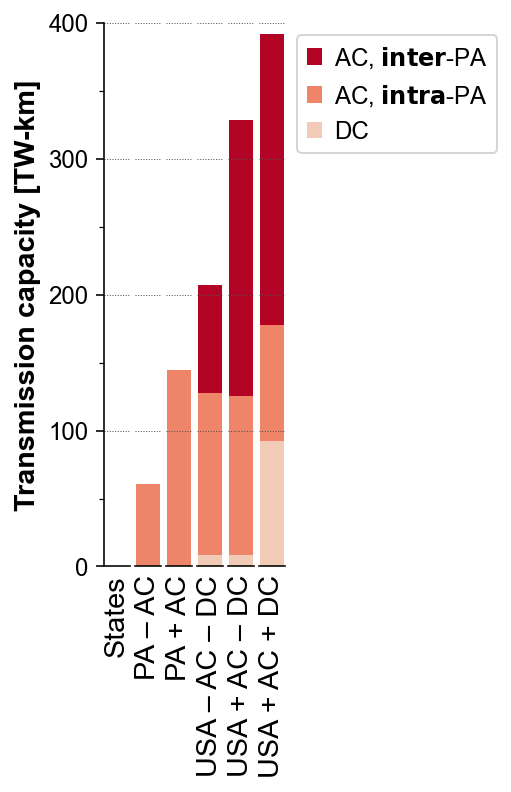

In [38]:
###### Include intra-PA inter-state transmission for full-US cases

figsize = (13/48*6,5)
frameon = False
color = 'C2'
alpha = 1
xlabels = ['States','PA – AC','PA + AC',
           'USA – AC – DC', 'USA + AC – DC', 'USA + AC + DC']
bc = {'ac_interba': plt.cm.coolwarm(1.0), 'ac_intraba': plt.cm.coolwarm(0.8), 
      'dc': plt.cm.coolwarm(0.6)}
legendlabels = {'dc': 'DC', 
                'ac_intraba': 'AC, '+r'$\bf{intra}$'+'-PA',
                'ac_interba': 'AC, '+r'$\bf{inter}$'+'-PA'}

##### Transmission scalers
transcost_adder = pd.read_csv(
    os.path.join(projpath,'io','transmission','transmission-adder-{}.csv').format(
        cases.loc[case,'intralevel_transcost']),
    index_col=0
)
### $/kW-km/yr
newac = zephyr.cpm.Line('a', 'b', defaults=defaults, voltage=500,)
newac_cost_annual = (
    newac.cost_distance * zephyr.cpm.crf(newac.wacc, newac.lifetime)
)
### 1000 GW-km / GW VRE
intraba_adder = (
    transcost_adder.transcost_ac_annual 
    / (newac_cost_annual * 1000) 
    / transcost_adder.cap_vre
)


plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')
###### States: Nothing!
###### PAs
for col, label in enumerate(['no new ac or dc','no new dc',]):
    ##### Bar
    dictplot = {}
    for ba in bas:
        lines = [c for c in dictout_ba[(yearindices[label][0],ba)]['cap'].index.values if '|' in c]
        lines = {
            x: [c for c in lines if c.endswith(x)]
            for x in ['dc_old','ac_old','dc_new','ac_new']
        }
        dictplot[ba] = pd.Series({
            line: 
            (dictout_ba[(barindex[label],ba)]['cap'][lines[line]].index.map(
                lambda x: dfdistance_state.loc[x.split('|')[0], x.split('_')[0].split('|')[1]]
             ).values * dictout_ba[(barindex[label],ba)]['cap'][lines[line]]
            ).sum() / 1000
            for line in lines
        })#.cumsum()
    dfplot = pd.concat(dictplot,axis=0).groupby(level=1).sum()
    ax[col+1].bar([2010], [dfplot.sum()], color=bc['ac_intraba'], alpha=alpha, width=7)
    print(col, label)
    print(dfplot)

###### USA
# for col, label in enumerate(['no new ac or dc']):
for col, label in enumerate(['no new ac or dc','no new dc','default']):
    lines = [c for c in dictout_usa[barindex[label]]['cap'].index.values if '|' in c]
    lines = {
        x: [c for c in lines if c.endswith(x)]
        for x in ['dc_old','ac_old','dc_new','ac_new']# traces[label]
    }
    
    ##### Bar
    df = pd.Series({
        line: 
        (dictout_usa[barindex[label]]['cap'][lines[line]].index.map(
            lambda x: dfdistance.loc[x.split('|')[0], x.split('_')[0].split('|')[1]]
         ).values * dictout_usa[barindex[label]]['cap'][lines[line]]
        ).sum() / 1000
        for line in ['dc_old','ac_old','dc_new','ac_new']
    })
    dfplot = pd.Series({'dc':df[['dc_old','dc_new']].sum(),
                        'ac_intraba': 0,
                        'ac_interba': df[['ac_old','ac_new']].sum()})
#     ### Add the intra-PA inter-state transmission associated with new VRE capacity
    dfplot['ac_intraba'] = sum(
        [dictout_usa[barindex[label]]['cap'][
            [c for c in dictout_usa[barindex[label]]['cap'].index 
             if (c.startswith('PV_{}'.format(ba)) or c.startswith('Wind_{}'.format(ba)))]
         ].sum() * intraba_adder[ba]
         for ba in bas
        ]
    )
    print(col, label)
    print(dfplot)
    dfplot = dfplot.cumsum()
    ### Plot it
    for line in ['ac_interba','ac_intraba','dc']:
        ax[col+3].bar([2010], dfplot[line], color=bc[line], alpha=alpha, width=7)
    print('{}: {:.2f}'.format(label, dfplot.max()))

### Legend (by hand)
handles = [
    mpl.patches.Patch(facecolor=bc[i], edgecolor='none', label=legendlabels[i])
    for i in bc
]
leg = ax[-1].legend(
    handles=handles,loc='upper left',bbox_to_anchor=(1,1),fontsize='large',
    frameon=True, handletextpad=0.5, handlelength=0.65,
)
### Formatting
for col in range(6):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(xlabels[col], rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
ax[0].yaxis.set_major_locator(MultipleLocator(100))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# l = np.arange(0,1001,100) ### or 100
# ax[0].set_yticks(l)
# ax[0].set_yticklabels(l, rotation=90, va='center')
ax[0].set_ylabel('Transmission capacity [TW-km]')
ax[0].set_ylim(0,400)
for col in range(1,6):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'statebausa-transmission-withadder-7yearbar'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

## Clean energy standard

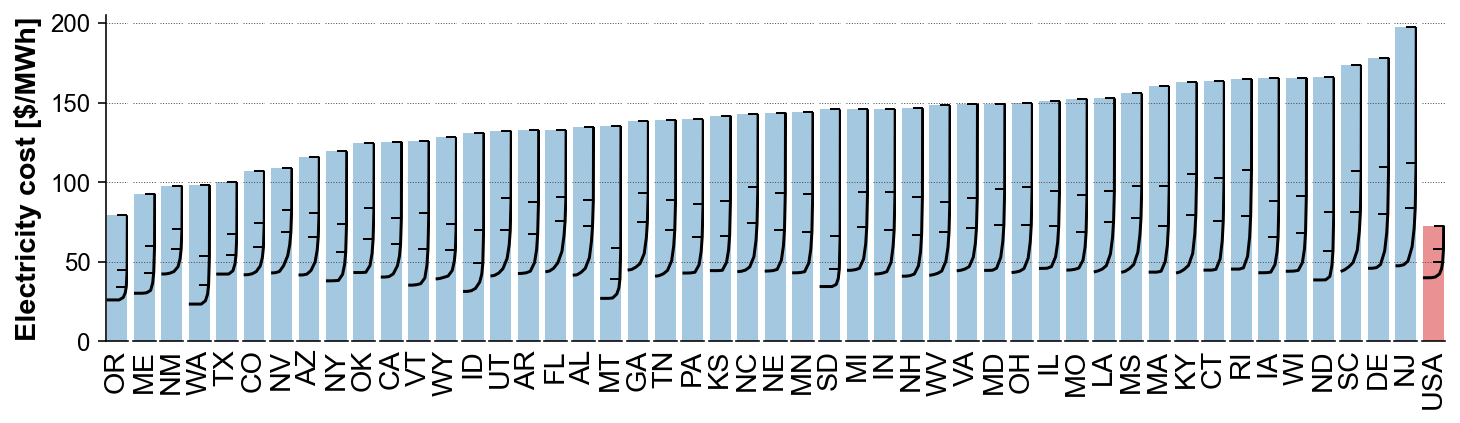

In [39]:
###### Use 7-year solutions instead
### Include markers for last few RPS levels
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice',
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'default',
]
rpss = [0,0.2,0.4,0.6,0.8,0.9,0.95,0.99,1]
color = 'C0'
alpha = 0.4
barcase = 7
markerrpss = [0.95,0.99,1.]

### Get state order
states_ordered = pd.Series(
    index=states, 
    data=[dictout_state[barcase,state]['values']['lcoe'] for state in states]
).sort_values().index.tolist()

plt.close()
f,ax=plt.subplots(1,49, figsize=(12,3), sharex=True, sharey='row')
for col, state in enumerate(states_ordered):
    lcoes = [dictout_state[barindex[label],state]['values']['lcoe']
             for label in plotlabels]
    ### Bar
    ax[col].bar([0.5], [dictout_state[barcase,state]['values']['lcoe']], color=color, alpha=alpha, width=1)
    ### Line
    ax[col].plot(rpss, lcoes, c='k', label='+ OCGT, CCGT\n- Nuclear', 
                 solid_capstyle='butt',
                 #marker='o', markersize=0.6, markeredgewidth=0.4,
                )
    ### Markers
    ax[col].plot(markerrpss, lcoes[-len(markerrpss):], lw=0, marker=0, c='k', ms=5)
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(state, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)

###### USA, default
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice',
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'default',
]
barcase = 23
### Calculate lines
objectives = pd.Series(
    [#max([dictout_usa[yearindices[label][i]]['values']['objective'] for i in range(7)])
     dictout_usa[barindex[label]]['values','objective']
     for label in plotlabels], index=rpss)
loadsums = pd.Series(
    [# max([dictout_usa[yearindices[label][i]]['values']['loadsum'] for i in range(7)])
     dictout_usa[barindex[label]]['values','loadsum']
     for label in plotlabels], index=rpss)
lcoes = objectives / loadsums * 1000
### Line, markers
ax[-1].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[-1].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)
### Bar
ax[-1].bar([0.5], [dictout_usa[barcase]['values']['lcoe']], color='C3', alpha=alpha+0.1, width=1)
ax[-1].set_xlabel('USA', rotation=90, weight='normal')
ax[-1].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
    
    
### Formatting
# ax[0].yaxis.set_major_locator(MultipleLocator(8))
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,205)
for col in range(1,49):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'states,usa-SCOE,rps-sharecolor'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

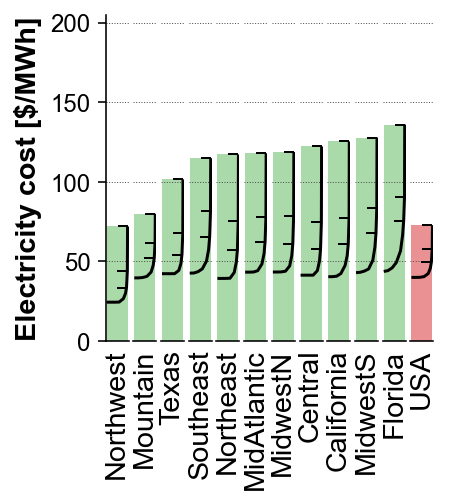

In [40]:
### Without new transmission
plotlabels = [
    '2030mid gasprice, no new ac or dc', 
    '20% RPS, 2030mid gasprice, no new ac or dc', '40% RPS, 2030mid gasprice, no new ac or dc',
    '60% RPS, 2030mid gasprice, no new ac or dc', '80% RPS, 2030mid gasprice, no new ac or dc',
    '90% RPS, 2030mid gasprice, no new ac or dc', '95% RPS, 2030mid gasprice, no new ac or dc', 
    '99% RPS, 2030mid gasprice, no new ac or dc',
    'no new ac or dc',
]
rpss = [0,0.2,0.4,0.6,0.8,0.9,0.95,0.99,1]
color = 'C2'
alpha = 0.4
barcase = barindex[plotlabels[-1]]
markerrpss = [0.95,0.99,1.]

### Get ba order
bas_ordered = pd.Series(
    index=bas, 
    data=[dictout_ba[barcase,ba]['values']['lcoe'] for ba in bas]
).sort_values().index.tolist()

plt.close()
f,ax=plt.subplots(1,12, figsize=(12/49*12,3), sharex=True, sharey='row')
for col, ba in enumerate(bas_ordered):
    lcoes = [
        # max([dictout_ba[yearindices[label][i],ba]['values']['lcoe'] for i in range(7)])
        dictout_ba[barindex[label],ba]['values','lcoe'] if (barindex[label],ba) in dictout_ba 
        # else np.nan
        else max([dictout_ba[yearindices[label][i],ba]['values']['lcoe'] for i in range(7)])
        for label in plotlabels]
    ### Bar
    ax[col].bar([0.5], [dictout_ba[barcase,ba]['values']['lcoe']], color=color, alpha=alpha, width=1)
    ### Line
    ax[col].plot(rpss, lcoes, c='k', label='+ OCGT, CCGT\n- Nuclear', 
                 solid_capstyle='butt',
                 #marker='o', markersize=0.6, markeredgewidth=0.4,
                )
    ### Markers
    ax[col].plot(markerrpss, lcoes[-len(markerrpss):], lw=0, marker=0, c='k', ms=5)
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(ba, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)

###### USA, default
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice',
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'default',
]
barcase = 23
### Calculate lines
objectives = pd.Series(
    [#max([dictout_usa[yearindices[label][i]]['values']['objective'] for i in range(7)])
     dictout_usa[barindex[label]]['values','objective']
     for label in plotlabels], index=rpss)
loadsums = pd.Series(
    [# max([dictout_usa[yearindices[label][i]]['values']['loadsum'] for i in range(7)])
     dictout_usa[barindex[label]]['values','loadsum']
     for label in plotlabels], index=rpss)
lcoes = objectives / loadsums * 1000
### Line, markers
ax[-1].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[-1].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)
### Bar
ax[-1].bar([0.5], [dictout_usa[barcase]['values']['lcoe']], color='C3', alpha=alpha+0.1, width=1)
ax[-1].set_xlabel('USA', rotation=90, weight='normal')
    
    
### Formatting
ax[-1].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
# ax[0].yaxis.set_major_locator(MultipleLocator(8))
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,205)
for col in range(1,12):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])

if save:
    savename = 'bas_notrans,usa-SCOE,rps-sharecolor'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

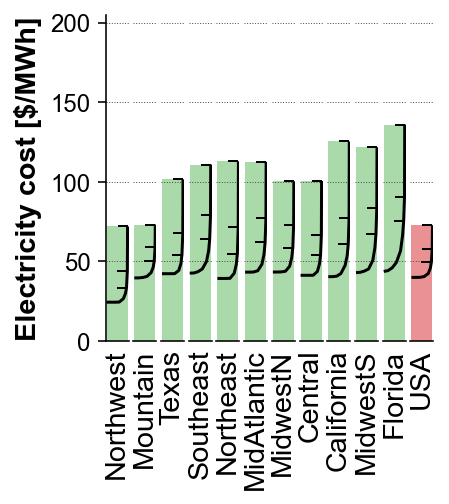

In [41]:
### With new transmission
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice', 
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'no new dc',
]
rpss = [0,0.2,0.4,0.6,0.8,0.9,0.95,0.99,1]
color = 'C2'
alpha = 0.4
barcase = barindex[plotlabels[-1]]
markerrpss = [0.95,0.99,1.]

# ### Get ba order
# bas_ordered = pd.Series(
#     index=bas, 
#     data=[dictout_ba[barcase,ba]['values']['lcoe'] for ba in bas]
# ).sort_values().index.tolist()

plt.close()
f,ax=plt.subplots(1,12, figsize=(12/49*12,3), sharex=True, sharey='row')
for col, ba in enumerate(bas_ordered):
    lcoes = [
        # max([dictout_ba[yearindices[label][i],ba]['values']['lcoe'] for i in range(7)])
        dictout_ba[barindex[label],ba]['values','lcoe'] if (barindex[label],ba) in dictout_ba 
        # else np.nan
        else max([dictout_ba[yearindices[label][i],ba]['values']['lcoe'] for i in range(7)])
        for label in plotlabels]
    ### Bar
    ax[col].bar([0.5], [dictout_ba[barcase,ba]['values']['lcoe']], color=color, alpha=alpha, width=1)
    ### Line
    ax[col].plot(rpss, lcoes, c='k', label='+ OCGT, CCGT\n- Nuclear', 
                 solid_capstyle='butt',
                 #marker='o', markersize=0.6, markeredgewidth=0.4,
                )
    ### Markers
    ax[col].plot(markerrpss, lcoes[-len(markerrpss):], lw=0, marker=0, c='k', ms=5)
    ### Formatting
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(ba, rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)

###### USA, default
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice',
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'default',
]
barcase = 23
### Calculate lines
objectives = pd.Series(
    [#max([dictout_usa[yearindices[label][i]]['values']['objective'] for i in range(7)])
     dictout_usa[barindex[label]]['values','objective']
     for label in plotlabels], index=rpss)
loadsums = pd.Series(
    [# max([dictout_usa[yearindices[label][i]]['values']['loadsum'] for i in range(7)])
     dictout_usa[barindex[label]]['values','loadsum']
     for label in plotlabels], index=rpss)
lcoes = objectives / loadsums * 1000
### Line, markers
ax[-1].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[-1].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)
### Bar
ax[-1].bar([0.5], [dictout_usa[barcase]['values']['lcoe']], color='C3', alpha=alpha+0.1, width=1)
ax[-1].set_xlabel('USA', rotation=90, weight='normal')
    
    
### Formatting
ax[-1].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
# ax[0].yaxis.set_major_locator(MultipleLocator(8))
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,205)
for col in range(1,12):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])

if save:
    savename = 'bas_withtrans,usa-SCOE,rps-sharecolor'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

States
0.00     0.000000
0.20     0.194329
0.40     0.780945
0.60     2.123791
0.80     7.418458
0.90    15.602179
0.95    24.480480
0.99    43.765726
1.00    93.157583
dtype: float64
PA + AC
0.00     0.000000
0.20     0.061985
0.40     0.400443
0.60     1.315611
0.80     5.122920
0.90    10.965354
0.95    17.516944
0.99    31.869606
1.00    65.229266
dtype: float64
USA + AC + DC
0.00     0.000000
0.20     0.000000
0.40     0.044456
0.60     0.488554
0.80     2.428163
0.90     5.794536
0.95     9.671714
0.99    17.895900
1.00    32.837040
dtype: float64


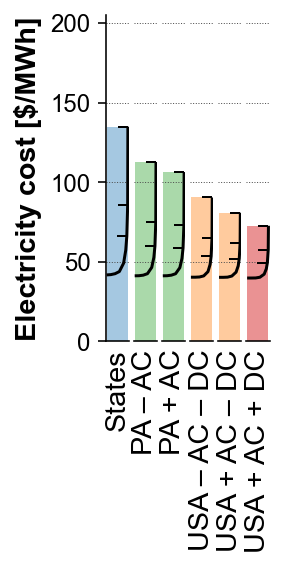

In [42]:
### Include markers for last few RPS levels
figsize = (12/49*6,3)
rpss = [0,0.2,0.4,0.6,0.8,0.9,0.95,0.99,1]
alpha = 0.4
markerrpss = [0.95,0.99,1.]


plt.close()
f,ax=plt.subplots(1,6, figsize=figsize, sharex=True, sharey='row')
###### States
color = 'C0'
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice',
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'default',
]
barcase = 7
### Calculate lines
objectives = pd.DataFrame(
    {state: [
        # max([dictout_state[yearindices[label][i],state]['values']['objective'] for i in range(7)])
        dictout_state[barindex[label],state]['values','objective']
        for label in plotlabels]
    for state in states},index=rpss).sum(axis=1)
loadsums = pd.DataFrame(
    {state: [
        # max([dictout_state[yearindices[label][i],state]['values']['loadsum'] for i in range(7)]) 
        dictout_state[barindex[label],state]['values','loadsum']
        for label in plotlabels]
    for state in states},index=rpss).sum(axis=1)
lcoes = objectives / loadsums * 1000
### Line, markers
ax[0].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[0].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)

### Bar
val = (sum([dictout_state[(barcase,state)]['values']['objective'] for state in states])
       / sum([dictout_state[(barcase,state)]['values']['loadsum'] for state in states])
      ) * 1000 ### Convert to $/MWh
ax[0].bar([0.5], [val], color=color, alpha=alpha, width=1)

### Log
print('States')
print(lcoes - lcoes[0.])

###### PAs, no new transmission
color = 'C2'
plotlabels = [
    '2030mid gasprice, no new ac or dc', '20% RPS, 2030mid gasprice, no new ac or dc', 
    '40% RPS, 2030mid gasprice, no new ac or dc', '60% RPS, 2030mid gasprice, no new ac or dc', 
    '80% RPS, 2030mid gasprice, no new ac or dc', '90% RPS, 2030mid gasprice, no new ac or dc', 
    '95% RPS, 2030mid gasprice, no new ac or dc', '99% RPS, 2030mid gasprice, no new ac or dc', 
    'no new ac or dc',
]
barcase = 7
### Calculate lines
objectives = pd.DataFrame(
    {ba: [
        # max([dictout_ba[yearindices[label][i],ba]['values']['objective'] for i in range(7)])
        dictout_ba[barindex[label],ba]['values','objective'] if (barindex[label],ba) in dictout_ba
        # else np.nan
        else max([dictout_ba[yearindices[label][i],ba]['values']['objective'] for i in range(7)]) * 7
        for label in plotlabels] 
     for ba in bas}, index=rpss).sum(axis=1)
loadsums = pd.DataFrame(
    {ba: [
        # max([dictout_ba[yearindices[label][i],ba]['values']['loadsum'] for i in range(7)])
        dictout_ba[barindex[label],ba]['values','loadsum'] if (barindex[label],ba) in dictout_ba
        # else np.nan
        else max([dictout_ba[yearindices[label][i],ba]['values']['loadsum'] for i in range(7)]) * 7
        for label in plotlabels]
     for ba in bas},index=rpss).sum(axis=1)
lcoes = objectives / loadsums * 1000
### Line + markers
ax[1].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[1].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)

### Bar
val = (sum([dictout_ba[(barcase,ba)]['values']['objective'] for ba in bas])
       / sum([dictout_ba[(barcase,ba)]['values']['loadsum'] for ba in bas])
      ) * 1000 ### Convert to $/MWh
ax[1].bar([0.5], [val], color=color, alpha=alpha, width=1)

###### PAs, with new transmission
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice', 
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'no new dc',
]
barcase = 15
### Calculate lines
objectives = pd.DataFrame(
    {ba: [
        # max([dictout_ba[yearindices[label][i],ba]['values']['objective'] for i in range(7)])
        dictout_ba[barindex[label],ba]['values','objective'] if (barindex[label],ba) in dictout_ba
        # else np.nan
        else max([dictout_ba[yearindices[label][i],ba]['values']['objective'] for i in range(7)]) * 7
        for label in plotlabels]
    for ba in bas},
    index=rpss
).sum(axis=1)
loadsums = pd.DataFrame(
    {ba: [
        # max([dictout_ba[yearindices[label][i],ba]['values']['loadsum'] for i in range(7)])
        dictout_ba[barindex[label],ba]['values','loadsum'] if (barindex[label],ba) in dictout_ba
        # else np.nan
        else max([dictout_ba[yearindices[label][i],ba]['values']['loadsum'] for i in range(7)]) * 7
        for label in plotlabels]
    for ba in bas}, index=rpss).sum(axis=1)
lcoes = objectives / loadsums * 1000
### Line + markers
ax[2].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[2].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)

### Bar
val = (sum([dictout_ba[(barcase,ba)]['values']['objective'] for ba in bas])
       / sum([dictout_ba[(barcase,ba)]['values']['loadsum'] for ba in bas])
      ) * 1000 ### Convert to $/MWh
ax[2].bar([0.5], [val], color=color, alpha=alpha, width=1)

print('PA + AC')
print(lcoes - lcoes[0.])

###### USA, no new ac or dc
color = 'C1'
plotlabels = [
    '2030mid gasprice, no new ac or dc', '20% RPS, 2030mid gasprice, no new ac or dc', 
    '40% RPS, 2030mid gasprice, no new ac or dc', '60% RPS, 2030mid gasprice, no new ac or dc', 
    '80% RPS, 2030mid gasprice, no new ac or dc', '90% RPS, 2030mid gasprice, no new ac or dc', 
    '95% RPS, 2030mid gasprice, no new ac or dc', '99% RPS, 2030mid gasprice, no new ac or dc', 
    'no new ac or dc',
]
barcase = 7
### Calculate lines
objectives = pd.Series(
    [#max([dictout_usa[yearindices[label][i]]['values']['objective'] for i in range(7)])
     dictout_usa[barindex[label]]['values','objective']
     for label in plotlabels], index=rpss)
loadsums = pd.Series(
    [# max([dictout_usa[yearindices[label][i]]['values']['loadsum'] for i in range(7)])
     dictout_usa[barindex[label]]['values','loadsum']
     for label in plotlabels], index=rpss)
lcoes = objectives / loadsums * 1000
### Line, markers
ax[3].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[3].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)
### Bar
ax[3].bar([0.5], [dictout_usa[barcase]['values']['lcoe']], color=color, alpha=alpha, width=1)

###### USA, no new dc
plotlabels = [
    '2030mid gasprice, no new dc', '20% RPS, 2030mid gasprice, no new dc', 
    '40% RPS, 2030mid gasprice, no new dc', '60% RPS, 2030mid gasprice, no new dc', 
    '80% RPS, 2030mid gasprice, no new dc', '90% RPS, 2030mid gasprice, no new dc', 
    '95% RPS, 2030mid gasprice, no new dc', '99% RPS, 2030mid gasprice, no new dc', 
    'no new dc',
]
barcase = 15
### Calculate lines
objectives = pd.Series(
    [#max([dictout_usa[yearindices[label][i]]['values']['objective'] for i in range(7)])
     dictout_usa[barindex[label]]['values','objective']
     for label in plotlabels], index=rpss)
loadsums = pd.Series(
    [# max([dictout_usa[yearindices[label][i]]['values']['loadsum'] for i in range(7)])
     dictout_usa[barindex[label]]['values','loadsum']
     for label in plotlabels], index=rpss)
lcoes = objectives / loadsums * 1000
### Line, markers
ax[4].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[4].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)
### Bar
ax[4].bar([0.5], [dictout_usa[barcase]['values']['lcoe']], color=color, alpha=alpha, width=1)

###### USA, default
color = 'C3'
plotlabels = [
    '2030mid VRES, 2030mid gas',
    '20% RPS, 2030mid gasprice', '40% RPS, 2030mid gasprice', '60% RPS, 2030mid gasprice',
    '80% RPS, 2030mid gasprice', '90% RPS, 2030mid gasprice', '95% RPS, 2030mid gasprice', 
    '99% RPS, 2030mid gasprice', 'default',
]
barcase = 23
### Calculate lines
objectives = pd.Series(
    [#max([dictout_usa[yearindices[label][i]]['values']['objective'] for i in range(7)])
     dictout_usa[barindex[label]]['values','objective']
     for label in plotlabels], index=rpss)
loadsums = pd.Series(
    [# max([dictout_usa[yearindices[label][i]]['values']['loadsum'] for i in range(7)])
     dictout_usa[barindex[label]]['values','loadsum']
     for label in plotlabels], index=rpss)
lcoes = objectives / loadsums * 1000
### Line, markers
ax[5].plot(rpss, lcoes.values, c='k', solid_capstyle='butt',)
ax[5].plot(markerrpss, lcoes.loc[markerrpss], lw=0, marker=0, c='k', ms=5)
### Bar
ax[5].bar([0.5], [dictout_usa[barcase]['values']['lcoe']], color=color, alpha=alpha+0.1, width=1)

print('USA + AC + DC')
print(lcoes - lcoes[0.])

###### Formatting
for col in range(6):
    ax[col].set_xticks([])
    ax[col].set_xticklabels([])
    ax[col].set_xlabel(xlabels[col], rotation=90, weight='normal')
    ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,205)
for col in range(1,6):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])

if save:
    savename = 'state,ba,usa-SCOE,rps-sharecolor'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

# Lost load in sensitivity cases with load-shedding

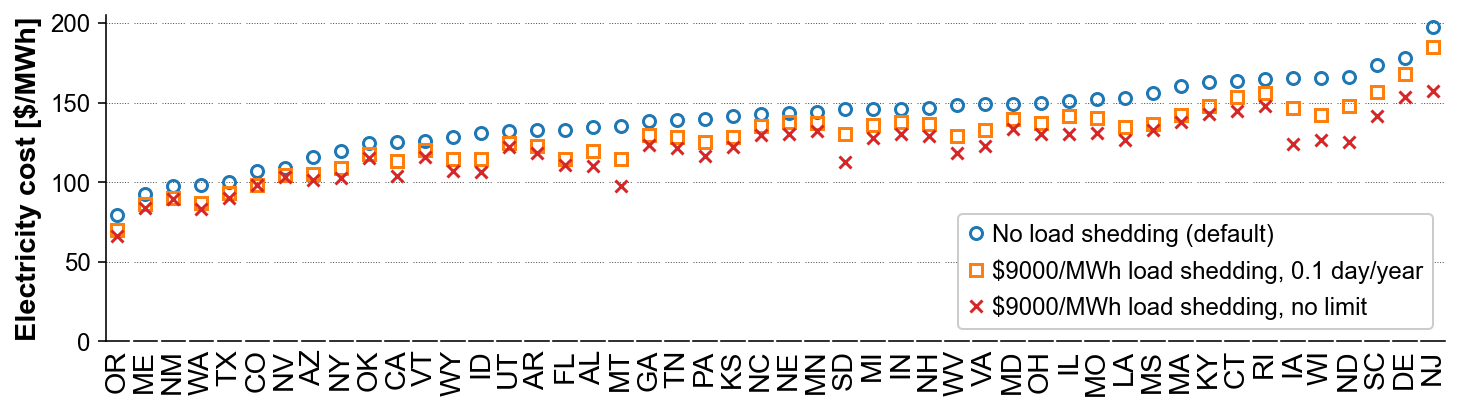

In [43]:
plotlabels = ['no new ac or dc', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
# tracelabels = ['No interruptible load (default)', 
#                '$9000/MWh interruptible load, 0.1 day/year', 
#                '$9000/MWh interruptible load, no limit']
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,len(states_ordered), figsize=(12,3), sharex=True, sharey='row')
for case in plotcases:
    for col, state in enumerate(states_ordered):
        ax[col].plot(
            [0], [dictout_state[case,state]['values','lcoe']],
            markeredgecolor=colors[case], marker=markers[case], 
            markerfacecolor='none', markeredgewidth=1.5, lw=0,
            label=tracelabels[case],
        )
        ### Formatting
        ax[col].set_xticks([])
        ax[col].set_xticklabels([])
        ax[col].set_xlabel(state, rotation=90, weight='normal')
        ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,205)
ax[-1].legend(
    loc='lower right', bbox_to_anchor=(1,0), frameon=True, fontsize='large',
    columnspacing=0.5, handletextpad=0.3,handlelength=0.7, framealpha=1)
for col in range(1,len(states_ordered)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'voll-scoe-states'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

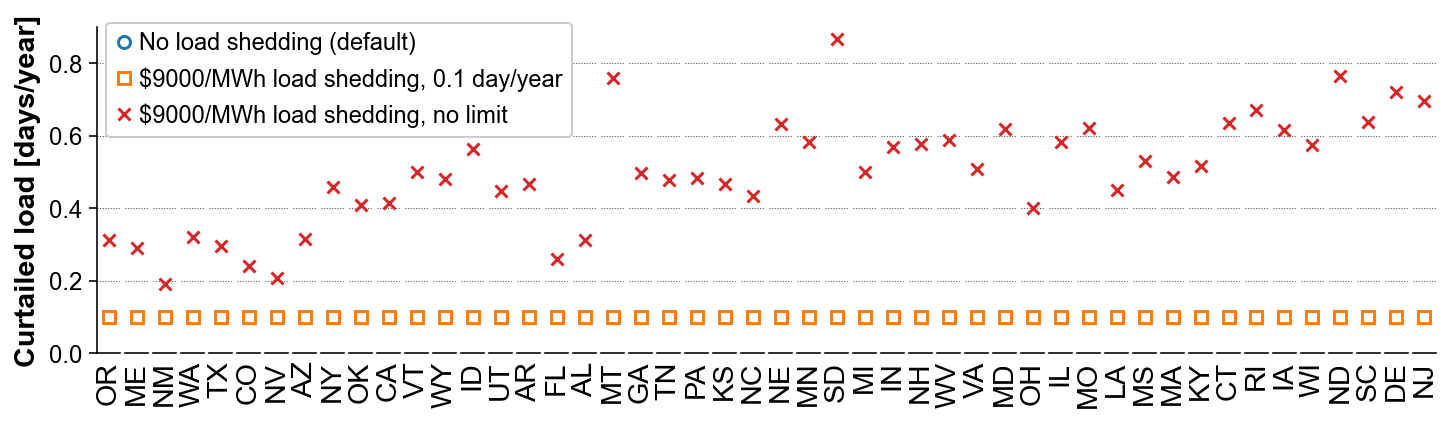

In [44]:
plotlabels = ['no new ac or dc', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,len(states_ordered), figsize=(12,3), sharex=True, sharey='row')
for case in plotcases:
    for col, state in enumerate(states_ordered):
        try:
            val = (dictout_state[case,state]['energy']['Lostload_{}'.format(state)]
                   / dictout_state[case,state]['values','loadsum'] * 365)
        except KeyError:
            val = 0
        ax[col].plot(
            [0], [val],
            markeredgecolor=colors[case], marker=markers[case], 
            markerfacecolor='none', markeredgewidth=1.5, lw=0,
            label=tracelabels[case],
        )
        ### Formatting
        ax[col].set_xticks([])
        ax[col].set_xticklabels([])
        ax[col].set_xlabel(state, rotation=90, weight='normal')
        ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Curtailed load [days/year]')
ax[0].set_ylim(0,0.9)
ax[-1].legend(
    loc='upper left', bbox_to_anchor=(-56.5,1.05), frameon=True, fontsize=11.8,
    columnspacing=0.5, handletextpad=0.3,handlelength=0.7, framealpha=1)
for col in range(1,len(states_ordered)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'voll-lostload-states'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

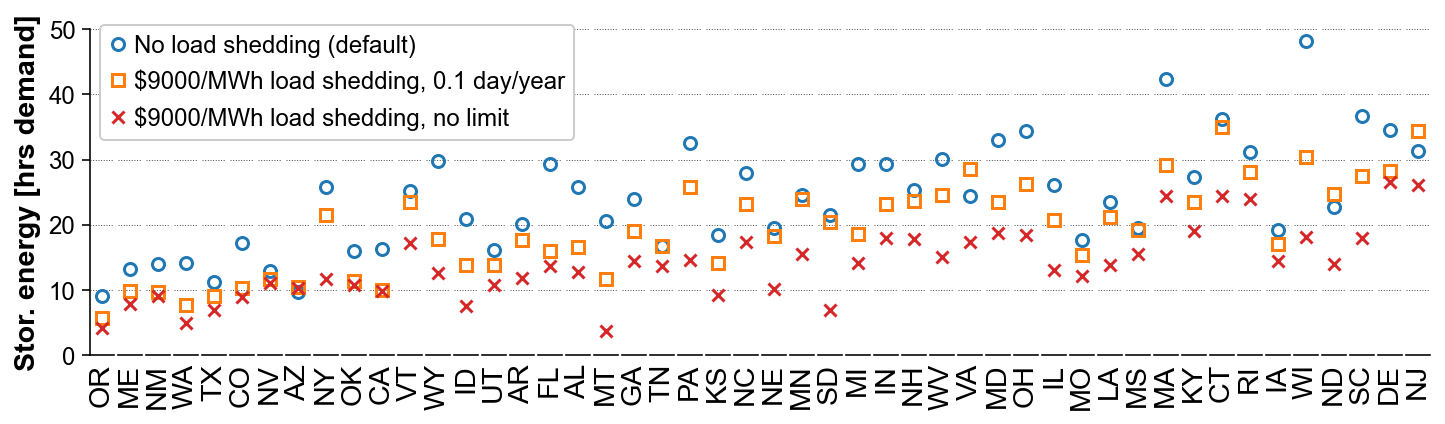

In [45]:
plotlabels = ['no new ac or dc', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,len(states_ordered), figsize=(12,3), sharex=True, sharey='row')
for case in plotcases:
    for col, state in enumerate(states_ordered):
        ax[col].plot(
            [0], 
            [(dictout_state[case,state]['cap','Stor_{}_E'.format(state)] 
              / dictout_state[case,state]['values','loadsum'] * len(opindex))],
            markeredgecolor=colors[case], marker=markers[case], 
            markerfacecolor='none', markeredgewidth=1.5, lw=0,
            label=tracelabels[case],
        )
        ### Formatting
        ax[col].set_xticks([])
        ax[col].set_xticklabels([])
        ax[col].set_xlabel(state, rotation=90, weight='normal')
        ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Stor. energy [hrs demand]')
ax[0].set_ylim(0,50)
ax[-1].legend(
    loc='upper left', bbox_to_anchor=(-56.5,1.05), frameon=True, fontsize=12,
    columnspacing=0.5, handletextpad=0.3,handlelength=0.7, framealpha=1)
for col in range(1,len(states_ordered)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'voll-stor_demand-states'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

In [46]:
ba2states = {
    ba: dfstate.loc[dfstate[('area','ba')]==ba].index.values.tolist()
    for ba in bas}

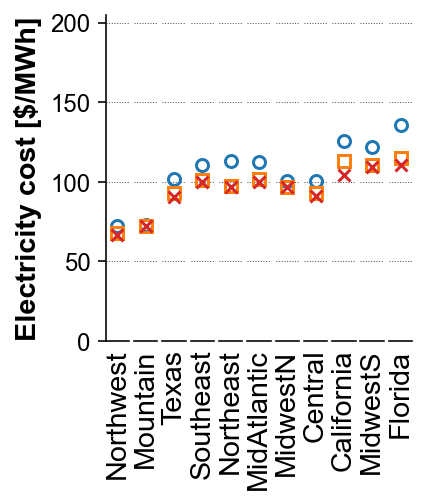

In [47]:
plotlabels = ['no new dc', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,len(bas_ordered), figsize=(12/48*11,3), sharex=True, sharey='row')
for case in plotcases:
    for col, ba in enumerate(bas_ordered):
        ax[col].plot(
            [0], [dictout_ba[case,ba]['values','lcoe']],
            markeredgecolor=colors[case], marker=markers[case], 
            markerfacecolor='none', markeredgewidth=1.5, lw=0,
            label=tracelabels[case],
        )
        ### Formatting
        ax[col].set_xticks([])
        ax[col].set_xticklabels([])
        ax[col].set_xlabel(ba, rotation=90, weight='normal')
        ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,205)
# ax[-1].legend(
#     loc='upper right', bbox_to_anchor=(0.2,1.07), frameon=False, fontsize=11,
#     columnspacing=0.5, handletextpad=0.3,handlelength=0.7,)
for col in range(1,len(bas_ordered)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'voll-scoe-BAs'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

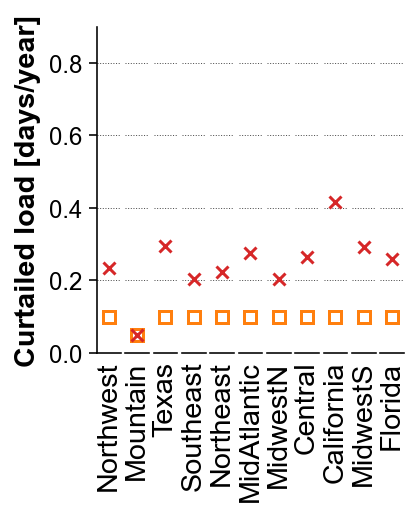

In [48]:
plotlabels = ['no new dc', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,len(bas_ordered), figsize=(12/48*11,3), sharex=True, sharey='row')
for case in plotcases:
    for col, ba in enumerate(bas_ordered):
        try:
            val = (
                sum([dictout_ba[case,ba]['energy']['Lostload_{}'.format(state)]
                     for state in ba2states[ba]])
                / dictout_ba[case,ba]['values','loadsum'] * 365)
        except KeyError:
            val = 0
        # print('{:>12} {:>12}: {:.6f}'.format(tracelabels[case],ba,val))
        ax[col].plot(
            [0], [val],
            markeredgecolor=colors[case], marker=markers[case], 
            markerfacecolor='none', markeredgewidth=1.5, lw=0,
            label=tracelabels[case],
        )
        ### Formatting
        ax[col].set_xticks([])
        ax[col].set_xticklabels([])
        ax[col].set_xlabel(ba, rotation=90, weight='normal')
        ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Curtailed load [days/year]')
ax[0].set_ylim(0,0.9)
# ax[-1].legend(
#     loc='upper right', bbox_to_anchor=(1,1), frameon=False, fontsize=11,
#     columnspacing=0.5, handletextpad=0.3,handlelength=0.7,)
for col in range(1,len(bas_ordered)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'voll-lostload-BAs'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

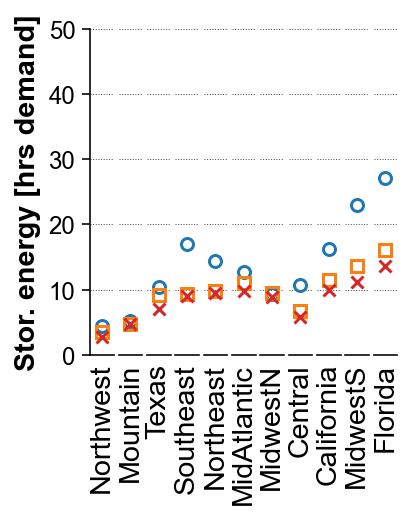

In [49]:
plotlabels = ['no new dc', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,len(bas_ordered), figsize=(12/48*11,3), sharex=True, sharey='row')
for case in plotcases:
    for col, ba in enumerate(bas_ordered):
        try:
            val = (
                sum([dictout_ba[case,ba]['cap']['Stor_{}_E'.format(state)]
                     for state in ba2states[ba]])
                / dictout_ba[case,ba]['values','loadsum'] * len(opindex))
        except KeyError:
            val = 0
        # print('{:>12} {:>12}: {:.6f}'.format(tracelabels[case],ba,val))
        ax[col].plot(
            [0], [val],
            markeredgecolor=colors[case], marker=markers[case], 
            markerfacecolor='none', markeredgewidth=1.5, lw=0,
            label=tracelabels[case],
        )
        ### Formatting
        ax[col].set_xticks([])
        ax[col].set_xticklabels([])
        ax[col].set_xlabel(ba, rotation=90, weight='normal')
        ax[col].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Stor. energy [hrs demand]')
ax[0].set_ylim(0,50)
# ax[-1].legend(
#     loc='upper right', bbox_to_anchor=(1,1), frameon=False, fontsize=11,
#     columnspacing=0.5, handletextpad=0.3,handlelength=0.7,)
for col in range(1,len(bas_ordered)):
    zephyr.plots.despine(ax[col],left=False)
zephyr.plots.despine(ax[0])
if save:
    savename = 'voll-stor_demand-BAs'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

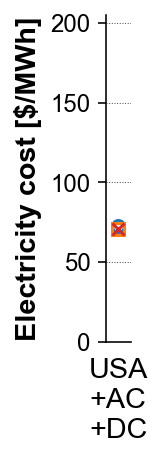

In [50]:
plotlabels = ['default', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,2, figsize=(12/48*2,3), sharex=True, sharey='row')
for case in plotcases:
    ax[0].plot(
        [0], [dictout_usa[case]['values','lcoe']],
        markeredgecolor=colors[case], marker=markers[case], 
        markerfacecolor='none', markeredgewidth=1.5, lw=0,
        label=tracelabels[case],
    )
    ### Formatting
    ax[0].set_xticks([])
    ax[0].set_xticklabels([])
    ax[0].set_xlabel('USA\n+AC\n+DC', weight='normal', labelpad=8)
    ax[0].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Electricity cost [$/MWh]')
ax[0].set_ylim(0,205)
# ax[0].legend(
#     loc='upper left', bbox_to_anchor=(1,1), frameon=False, fontsize=11,
#     columnspacing=0.5, handletextpad=0.3,handlelength=0.7,)
zephyr.plots.despine(ax)
ax[1].remove()
if save:
    savename = 'voll-scoe-usa'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

No load shedding (default): nan
$9000/MWh load shedding, 0.1 day/year: 0.099573
$9000/MWh load shedding, no limit: 0.099573


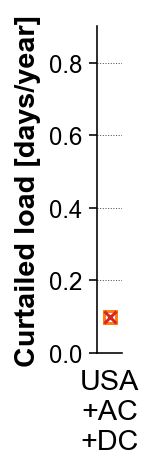

In [51]:
plotlabels = ['default', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,2, figsize=(12/48*2,3), sharex=True, sharey='row')
for case in plotcases:
    try:
        val = (
            sum([dictout_usa[case]['energy']['Lostload_{}'.format(ba)]
                 for ba in bas])
            / dictout_usa[case]['values','loadsum'] * 365)
    except KeyError:
        val = 0
    print('{}: {:.6f}'.format(tracelabels[case],val))
    ax[0].plot(
        [0], [val],
        markeredgecolor=colors[case], marker=markers[case], 
        markerfacecolor='none', markeredgewidth=1.5, lw=0,
        label=tracelabels[case],
    )
    ### Formatting
    ax[0].set_xticks([])
    ax[0].set_xticklabels([])
    ax[0].set_xlabel('USA\n+AC\n+DC', weight='normal', labelpad=8)
    ax[0].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Curtailed load [days/year]')
ax[0].set_ylim(0,0.9)
# ax[0].legend(
#     loc='upper left', bbox_to_anchor=(1,1), frameon=False, fontsize=11,
#     columnspacing=0.5, handletextpad=0.3,handlelength=0.7,)
zephyr.plots.despine(ax)
ax[1].remove()
if save:
    savename = 'voll-lostload-usa'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()

No load shedding (default): 5.258913
$9000/MWh load shedding, 0.1 day/year: 2.947042
$9000/MWh load shedding, no limit: 2.947042


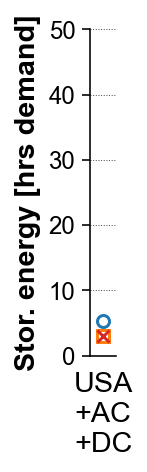

In [52]:
plotlabels = ['default', '$9000/MWh VOLL, 0.1day/year', '$9000/MWh load shedding', ]
tracelabels = ['No load shedding (default)', 
               '$9000/MWh load shedding, 0.1 day/year', 
               '$9000/MWh load shedding, no limit']
plotcases = [barindex[label] for label in plotlabels]
tracelabels = dict(zip(plotcases, tracelabels))
markers = dict(zip(plotcases, ['o','s','x']))
colors = dict(zip(plotcases, ['C0','C1','C3']))

plt.close()
f,ax=plt.subplots(1,2, figsize=(12/48*2,3), sharex=True, sharey='row')
for case in plotcases:
    try:
        val = (
            sum([dictout_usa[case]['cap']['Stor_{}_E'.format(ba)]
                 for ba in bas])
            / dictout_usa[case]['values','loadsum'] * len(opindex))
    except KeyError:
        val = 0
    print('{}: {:.6f}'.format(tracelabels[case],val))
    ax[0].plot(
        [0], [val],
        markeredgecolor=colors[case], marker=markers[case], 
        markerfacecolor='none', markeredgewidth=1.5, lw=0,
        label=tracelabels[case],
    )
    ### Formatting
    ax[0].set_xticks([])
    ax[0].set_xticklabels([])
    ax[0].set_xlabel('USA\n+AC\n+DC', weight='normal', labelpad=8)
    ax[0].grid(which='major', axis='y', c='0.3', ls=':', lw=0.5)
### Formatting
ax[0].set_ylabel('Stor. energy [hrs demand]')
ax[0].set_ylim(0,50)
# ax[0].legend(
#     loc='upper left', bbox_to_anchor=(1,1), frameon=False, fontsize=11,
#     columnspacing=0.5, handletextpad=0.3,handlelength=0.7,)
zephyr.plots.despine(ax)
ax[1].remove()
if save:
    savename = 'voll-stor_demand-usa'
    print(figpath+savename)
    plt.savefig(figpath+savename+'.png')
    plt.savefig(figpath+savename+'.pdf')
plt.show()